# Initial Steps

For this thesis we will focus on a series of experiments.

Here's the plan we are going to follow:

1. Data Loading and Basic Exploration:
  - We will load the provided datasets and explore the first few rows to understand its structure.

2. Data Preprocessing:
  - Here we will clean, encode, and scale the dataset.

3. Initial Model Training:
  - We plan on using a variety of machine learning models to predict the target variable. This step will give us an idea about which models are best suited for this dataset in terms of accuracy.

4. Model Selection
  - We will select one model and use that one for the experiments.

3. Bias Identification using SHAP:
  - **Experiment 1**: Use SHAP values to identify the main predictors of outcome. This will help us understand which features are driving the predictions and potentially contributing to biases.

4. Disparate Impact Analysis:
  - We will assess if there's any disparate impact on a particular group by analyzing the predictions. This will give us an idea of how biased the model predictions are.

5. Permutation Feature Importance for Bias:
  - **Experiment 2**: We repurpose permutation feature importance to highlight the features that contribute significantly to model bias.


6. Targeted Debiasing through Resampling
  - **Experiment 3**: Resampling strategy, aiming to modify the distribution of underrepresented groups to match that of a reference group

7. Distribution Mapping
  - **Experiment 4**: Process of deriving target distributions based on the most
favorable group

8. Analysis and Plots:
  - After each section, we will provide plots and a analysis to understand the results.



In [ ]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import plotly.express as px
import scipy.stats as stats
import sklearn
import xgboost as xgb

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.feature_selection import SelectKBest, f_classif


from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.inspection import permutation_importance

from xgboost import XGBClassifier

from sklearn.utils import resample

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings(action='ignore', category=FutureWarning)
import matplotlib.font_manager as fm

%matplotlib inline

# Data

## Encoded Clean dataset

In [ ]:
# sc_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/UCL Notebooks/Holistic AI/Bias Holistic AI/clean_encoded_adult_train.csv', na_values='?')
# sc_train = sc_train.applymap(lambda x: x.strip() if isinstance(x, str) else x)
# train_data = sc_train.copy()

# sc_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/UCL Notebooks/Holistic AI/Bias Holistic AI/clean_encoded_adult_test.csv', na_values='?')
# sc_test = sc_test.applymap(lambda x: x.strip() if isinstance(x, str) else x)
# test_data = sc_test.copy()

sc_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/UCL Notebooks/Holistic AI/Bias Holistic AI/clean_encoded_adult_train_v2.csv', na_values='?')
sc_train = sc_train.applymap(lambda x: x.strip() if isinstance(x, str) else x)
train_data = sc_train.copy()

sc_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/UCL Notebooks/Holistic AI/Bias Holistic AI/clean_encoded_adult_test_v2.csv', na_values='?')
sc_test = sc_test.applymap(lambda x: x.strip() if isinstance(x, str) else x)
test_data = sc_test.copy()



print("Training set:", train_data.shape)
print("Testing set:", test_data.shape)

Training set: (30162, 43)
Testing set: (15060, 43)


In [ ]:
# Spliting the data into features and target variable
X_train = train_data.drop('outcome', axis=1)
y_train = train_data['outcome']
X_test = test_data.drop('outcome', axis=1)
y_test = test_data['outcome']

print("Training set:", X_train.shape)
print("Testing set:", X_test.shape)

Training set: (30162, 42)
Testing set: (15060, 42)


In [ ]:
X_train.head()

,age,edunum,race,sex,capgain,caploss,hoursweek,country,workclass_Federal-gov,workclass_Local-gov,...,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,relationship_Husband,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife
0,0.301370,0.800000,1.0,1.0,0.02174,0.0,0.397959,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.452055,0.800000,1.0,1.0,0.00000,0.0,0.122449,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.287671,0.533333,1.0,1.0,0.00000,0.0,0.397959,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.493151,0.400000,0.0,1.0,0.00000,0.0,0.397959,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.150685,0.800000,0.0,0.0,0.00000,0.0,0.397959,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


# Model comparison

**Initial Model Training:**

We will use a variety of machine learning models to predict the target variable. This step will give us an idea about which models are best suited for this dataset in terms of accuracy.

In [ ]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
    "SVM (Linear Kernel)": SVC(kernel="linear", max_iter=1000, random_state=42)
}

# Training models and evaluate accuracy on the test set
model_accuracies = {}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    model_accuracies[model_name] = accuracy

model_accuracies

{'Logistic Regression': 0.8467463479415671,
 'Decision Tree': 0.80464807436919,
 'Random Forest': 0.8345285524568393,
 'XGBoost': 0.8525232403718459,
 'SVM (Linear Kernel)': 0.5715139442231075}

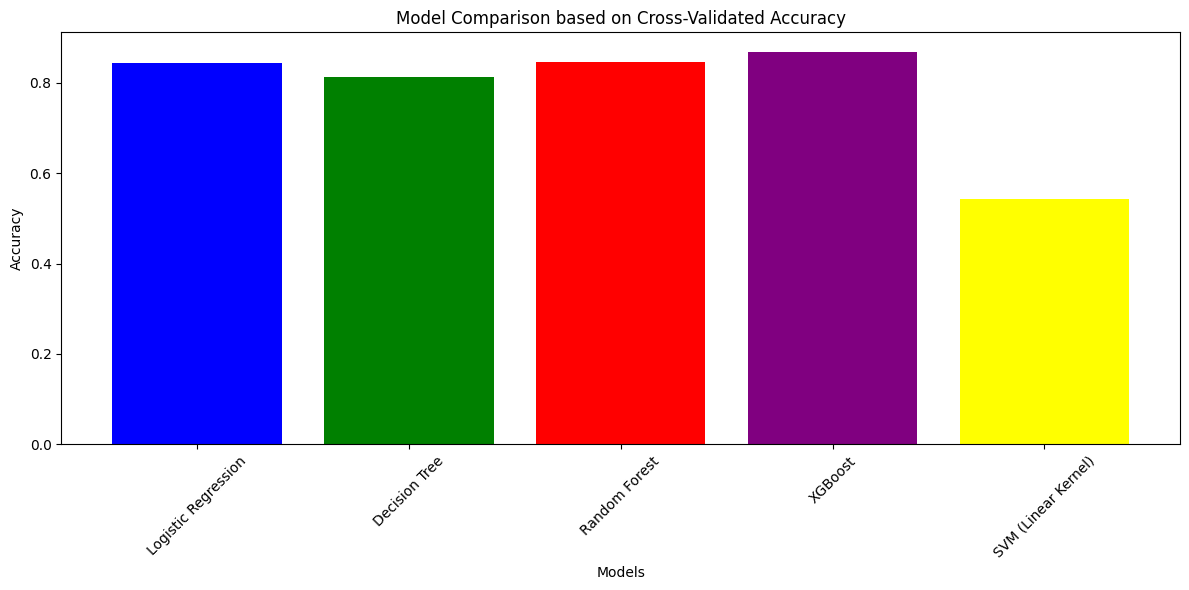

{'Logistic Regression': 0.845070228245094,
 'Decision Tree': 0.8132089434282973,
 'Random Forest': 0.8454016668271457,
 'XGBoost': 0.8686760834860081,
 'SVM (Linear Kernel)': 0.5429718555020773}

In [ ]:
# cross-validation to get the best performance
cv_scores = {}
for model_name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores[model_name] = scores.mean()

# Plotting the comparison of accuracy of the different models
plt.figure(figsize=(12, 6))
plt.bar(cv_scores.keys(), cv_scores.values(), color=['blue', 'green', 'red', 'purple', 'yellow'])
plt.ylabel('Accuracy')
plt.xlabel('Models')
plt.title('Model Comparison based on Cross-Validated Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

cv_scores

## Model Selection

Performance Metrics Breakdown for Logistic Regression

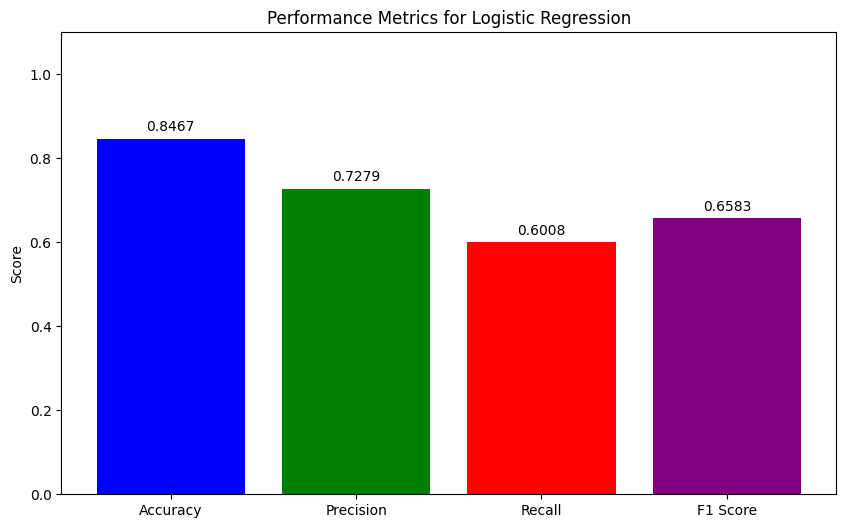

In [ ]:
# Predictions from the logistic regression model
predictions = models["Logistic Regression"].predict(X_test)

# Computing metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

# Plotting
metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]
values = [accuracy, precision, recall, f1]

plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color=['blue', 'green', 'red', 'purple'])
for i, bar in enumerate(bars):
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, '{:.4f}'.format(values[i]), ha='center', va='bottom')

# plt.bar(metrics, values, color=['blue', 'green', 'red', 'purple'])
plt.ylim(0, 1.1)
plt.ylabel("Score")
plt.title("Performance Metrics for Logistic Regression")
plt.show()

In [ ]:
# Predicting with the original Logistic Regression model on the test set
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)
original_predictions = logistic_model.predict(X_test)

# Computing the accuracy
original_accuracy = accuracy_score(y_test, original_predictions)

original_accuracy

0.846879150066401

# Experiments 🤖

## Experiment 1: Bias Detection

In [ ]:
pip install shap

In [ ]:
import shap

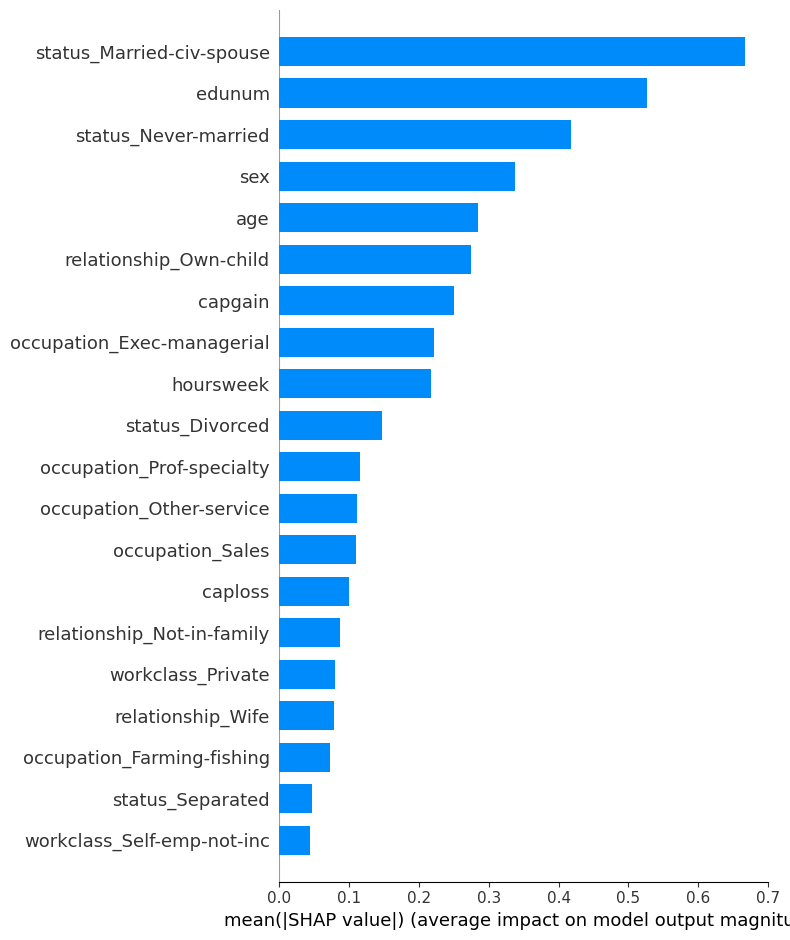

In [ ]:
# Initializing the explainer for the Logistic Regression model
explainer = shap.LinearExplainer(models["Logistic Regression"], X_train, feature_dependence="independent")
shap_values = explainer.shap_values(X_test)

# Visualizing the summary of SHAP values (mean absolute SHAP value for each feature)
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [ ]:
# Computing SHAP values for the Logistic Regression model
explainer = shap.LinearExplainer(models["Logistic Regression"], X_train, feature_purturbation="interventional")
shap_values = explainer.shap_values(X_test)

# Summarizing the SHAP values for the entire test set
shap_summary = np.mean(np.abs(shap_values), axis=0)

shap_summary

array([2.84515906e-01, 5.26922647e-01, 2.63311700e-02, 3.36800842e-01,
       2.50336026e-01, 9.92888419e-02, 2.16779478e-01, 2.81703187e-02,
       2.73975141e-02, 2.15391121e-03, 8.02140063e-02, 2.17154067e-02,
       4.42710851e-02, 8.71835927e-03, 9.87127093e-03, 1.47366100e-01,
       1.14694495e-03, 6.66849625e-01, 6.07981541e-03, 4.17724755e-01,
       4.59209827e-02, 1.75829433e-02, 3.18691118e-02, 1.19664235e-04,
       4.27118131e-02, 2.20766363e-01, 7.21454587e-02, 3.98958769e-02,
       1.66230027e-02, 1.11031817e-01, 8.46397695e-03, 1.14888099e-01,
       4.26637274e-02, 1.09489202e-01, 4.01825140e-02, 7.14991888e-03,
       2.36841892e-02, 8.74234264e-02, 2.25931076e-02, 2.74687438e-01,
       1.15616181e-02, 7.76787386e-02])

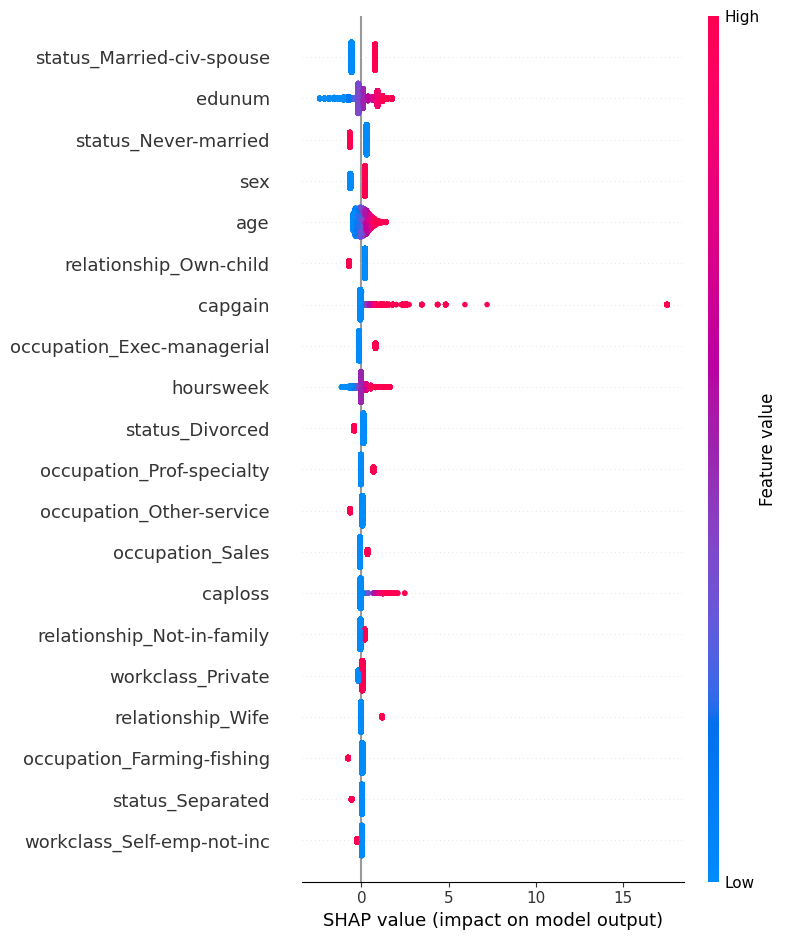

In [ ]:
# Plotting the global SHAP values
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test)

Interpretation:
- Features on the Y-axis: The features are ordered from top to bottom by their overall importance. Importance is determined by the average magnitude of the SHAP values for each feature.

- Horizontal Location: The location on the X-axis indicates the effect of the feature value on the model's prediction. Values to the right of the vertical red line indicate a positive effect (increasing the output of the model), and values to the left indicate a negative effect (decreasing the output).

- Color: The color represents the value of the feature. Red indicates a high feature value, while blue indicates a low feature value.

- Distribution of SHAP Values: The density of points for a feature provides insight into the distribution of that feature's effects across all instances. For example, a wide spread of points indicates that a feature has a varied impact on different instances, while a narrow spread indicates a more consistent effect.

Key Observations:
1. edunum (education number) is the most influential feature, with higher values (red) generally pushing the model's prediction towards a higher income.

2. capgain (capital gain) is the second most influential feature, and again, higher values tend to result in predictions of higher income.

3. relationship_Husband and sex (gender) also play significant roles. Being a husband or being male often contributes to predictions of higher income.

4. Features like status_Never-married have a notable negative impact on the prediction, pushing it towards a lower income.

5. There are several features that have a mix of positive and negative impacts, indicating the complexity of their interactions with other features and the outcome.

This global perspective provides insights into which features drive the model's decisions and in what direction. It's essential for understanding the model's behaviour and can be a starting point for addressing potential biases.

### Detailed SHAP Analysis

A detailed SHAP analysis will help us understand how each feature influences specific predictions, which can provide deeper insights into potential biases.

**Steps for Detailed SHAP Analysis:**
1. Force Plots for Individual Instances:
  - These plots break down the prediction for an individual instance to show the contribution of each feature. This can provide insights into why the model made a particular prediction for an individual.
2. SHAP Dependence Plots:
  - These plots visualise how a single feature affects the output of the model, adjusted for the average effects of all other features. They can provide insights into interactions between features.

In [ ]:
# Selecting a few individual instances for detailed SHAP analysis
sample_indices = [10, 20, 30]

# Visualizing the SHAP values for the selected instances using force plots
shap.initjs()
force_plot_objects = [shap.force_plot(explainer.expected_value, shap_values[i], X_test.iloc[i]) for i in sample_indices]

# force_plot_objects

shap.initjs()
display(force_plot_objects[0])
display(force_plot_objects[1])
display(force_plot_objects[2])

The force plots above display the contributions of each feature for the selected instances.

1. Base Value: This is the model's output when considering the average of the dataset. It's the starting point for our prediction.
2. Red and Blue Features: The features are colored based on their values for the specific instance. Red indicates high values, while blue indicates low values.
3. Feature Contributions: The length and direction of the bars represent the magnitude and direction of each feature's contribution. Features pushing the prediction higher are on the right (positive contribution), while those pushing the prediction lower are on the left (negative contribution).
4. Output Value: This is the model's final prediction for the instance, considering all feature contributions.

For example, looking at the first plot:

- Features like edunum (education number) with higher values are pushing the prediction towards a higher income.
- In contrast, features like age or status_Never-married might be pulling the prediction in the opposite direction.


By examining such plots for various instances, especially those where the model might be making biased predictions, we can get a clearer understanding of which features are influencing those decisions.

**SHAP dependence plots**

These plots visualize the relationship between SHAP values and feature values, helping to uncover potential interactions. We'll start with a few key features identified earlier, such as edunum and capgain.

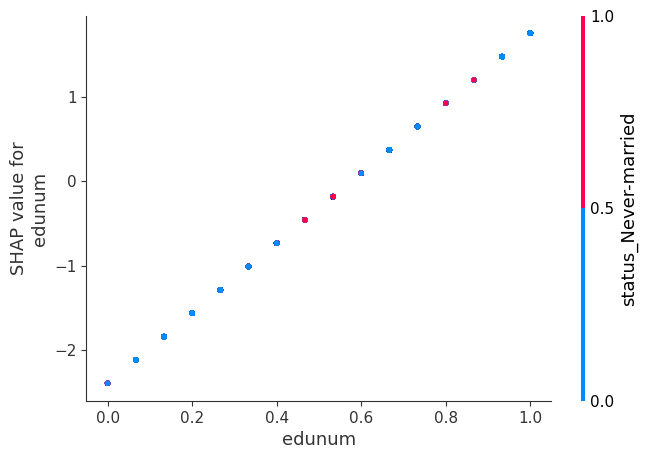

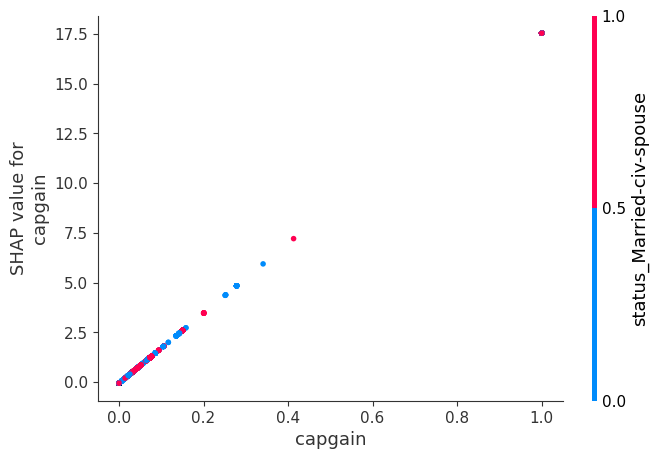

In [ ]:
# Visualizing SHAP Dependence Plots for key features
features_for_dependence = ["edunum", "capgain"]

# Plotting dependence plots
for feature in features_for_dependence:
    shap.dependence_plot(feature, shap_values, X_test, display_features=X_test)

The SHAP Dependence Plots provide a visual representation of the relationship between feature values and their corresponding SHAP values.

- X-axis: Represents the value of the selected feature for each instance.
- Y-axis: Represents the SHAP value, indicating the impact of the feature on the model's prediction.
- Color: Each point is colored by the value of another feature, showing potential interactions between features.


**Results:**
1. edunum (Education Number) Plot:

  - As the number of years of education (edunum) increases, its SHAP value generally increases, indicating a positive correlation between education level and the likelihood of having a higher income.
  - The color represents the age of individuals. we can observe some interactions, especially for younger individuals with fewer years of education, where the SHAP values tend to be lower.

2. capgain (Capital Gain) Plot:

  - For most instances, when capital gain (capgain) is zero, the SHAP value is negative, meaning it reduces the prediction. However, as the capital gain increases, its impact becomes more positive, pushing the prediction towards higher income.
  - The color represents the education number (edunum). There's a noticeable interaction where individuals with higher capital gains and more years of education tend to have higher SHAP values.


**Key Takeaways:**

- The dependence plots confirm some of the relationships observed in the global SHAP summary, specifically the positive influence of education number and capital gain on income predictions.
- They also hint at interactions between features. For instance, age might interact with education, and education might interact with capital gain, influencing the model's decisions.

These insights can be crucial when considering bias mitigation strategies, as they help pinpoint not only individual features but also feature interactions that might contribute to biased predictions.

In [ ]:
knn = sklearn.neighbors.KNeighborsClassifier()
knn.fit(X_train, y_train)

f = lambda x: knn.predict_proba(x)[:,1]
med = X_train.median().values.reshape((1,X_train.shape[1]))

explainer2 = shap.Explainer(f, med)
shap_values = explainer2(X_test.iloc[0:5000,:])
# shap_values = explainer2(X_test) #takes too long to run on the entire set

Permutation explainer: 5001it [34:32,  2.40it/s]


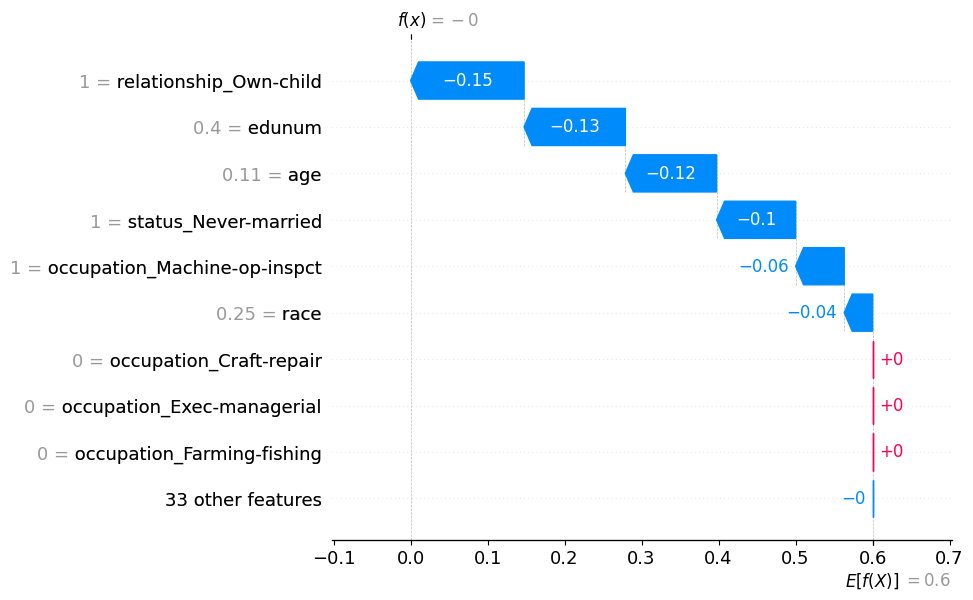

In [ ]:
shap.plots.waterfall(shap_values[0])

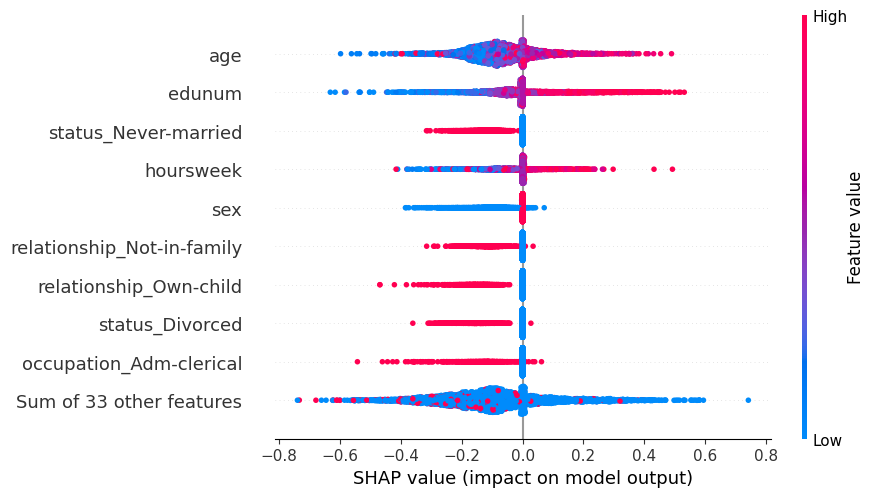

In [ ]:
shap.plots.beeswarm(shap_values)

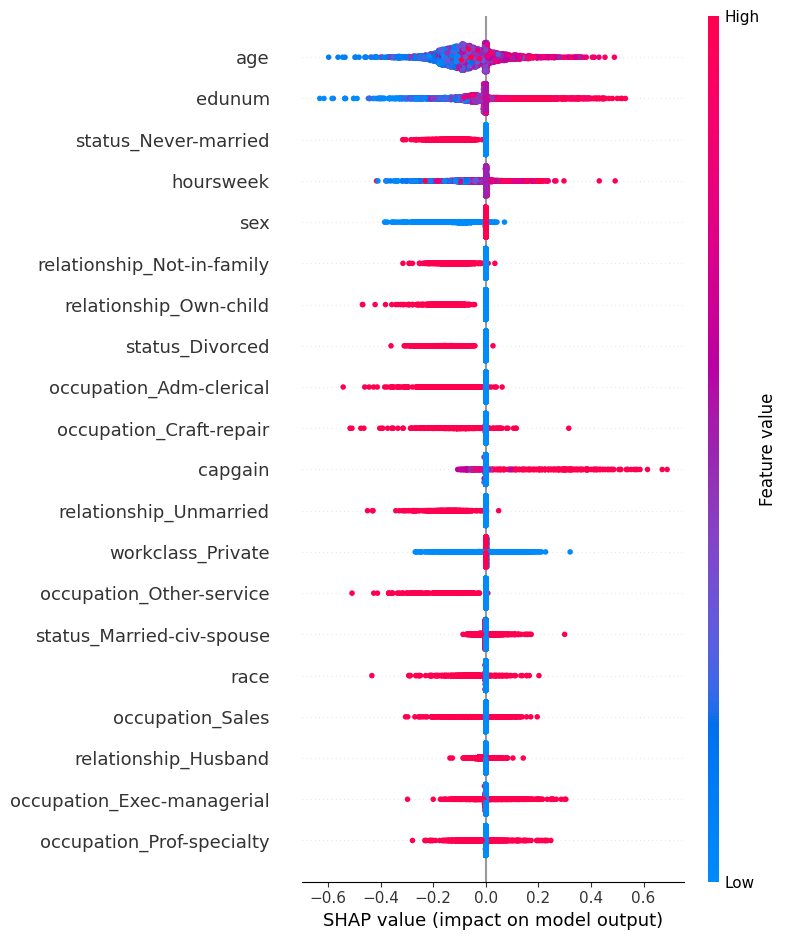

In [ ]:
shap.summary_plot(shap_values, X_test.iloc[0:5000,:])
# shap.summary_plot(shap_values, X_test)

### Disparate Impact

In [ ]:
# predictions from the Logistic Regression model
predictions = models["Logistic Regression"].predict(X_test)

# function to compute disparate impact
def compute_disparate_impact(predictions, protected_attribute):
    # Split predictions based on the protected attribute
    favorable_privileged = predictions[(protected_attribute == 1) & (predictions == 1)].shape[0]
    total_privileged = protected_attribute.sum()

    favorable_unprivileged = predictions[(protected_attribute == 0) & (predictions == 1)].shape[0]
    total_unprivileged = (protected_attribute == 0).sum()

    # Calculate disparate impact
    if favorable_privileged / total_privileged == 0:  # Avoiding division by zero
        return 0
    else:
        return (favorable_unprivileged / total_unprivileged) / (favorable_privileged / total_privileged)

# disparate impact for sex and race
disparate_impacts = {
    "Sex": compute_disparate_impact(predictions, X_test["sex"].values),
    "Race": compute_disparate_impact(predictions, (X_test["race"].values))
}

disparate_impacts

{'Sex': 0.2926215590527515, 'Race': 0.565367672323164}

The Disparate Impact values for the protected attributes are:

1. Sex (Female vs. Male): 0.29262
2. Race (Minorities vs. Non-minorities): 0.5653

Interpretation:

1. For Sex: The value of 0.292 means that females are almost 3 times less likely to receive favorable outcomes compared to males. This indicates a significant disparate impact against the unprivileged group (females) in terms of gender.
2. For Race: A disparate impact value of 0.5653 for race suggests that the unprivileged group (e.g., non-whites) has a rate of favorable outcomes that is approximately 56.53% of the rate of favorable outcomes for the privileged group (e.g., whites). Ideally, in a fair model, this value should be close to 1.0, indicating equal rates of favorable outcomes for both groups. The value 0.5653 signifies a potential bias against the unprivileged group in the model's predictions.

These results underline the presence of biases in the model's predictions. The next step would be to identify the features contributing to these biases and mitigate them.

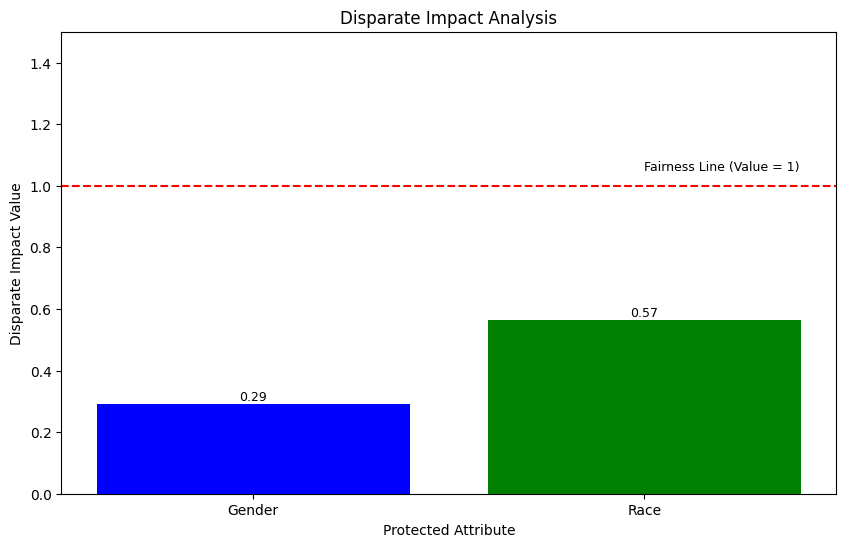

In [ ]:
x_names = ['Gender','Race']

# Plotting the disparate impact values
plt.figure(figsize=(10, 6))
bars = plt.bar(x_names, disparate_impacts.values(), color=['blue', 'green'])
# plt.bar(x_names, disparate_impacts.values(), color=['blue', 'green'])
plt.axhline(y=1, color='red', linestyle='--')  # Line indicating fairness
plt.ylabel('Disparate Impact Value')
plt.xlabel('Protected Attribute')
plt.title('Disparate Impact Analysis')
plt.ylim(0, 1.5)
# plt.annotate('Fairness Line (Value = 1)', xy=(1, 1.05), color='red', fontsize=9)
plt.annotate('Fairness Line (Value = 1)', xy=(1, 1.05), fontsize=9)


for bar in bars:
    yval = bar.get_height()
    plt.annotate(f'{yval:.2f}', (bar.get_x() + bar.get_width() / 2, yval), ha='center', va='bottom', fontsize=9)

plt.show()

Detailed disparate impact


We'll approach this in the following sequence:

1. Confusion Matrices for Each Subgroup: This will allow us to compare the model's performance for the privileged and unprivileged groups. We'll look at the confusion matrices for both the sex and race attributes.
2. Distribution of Key Features: We'll visualize the distribution of important features among the privileged and unprivileged groups.
3. Other Fairness Metrics: Equal Opportunity Difference and Average Odds Difference to assess fairness.

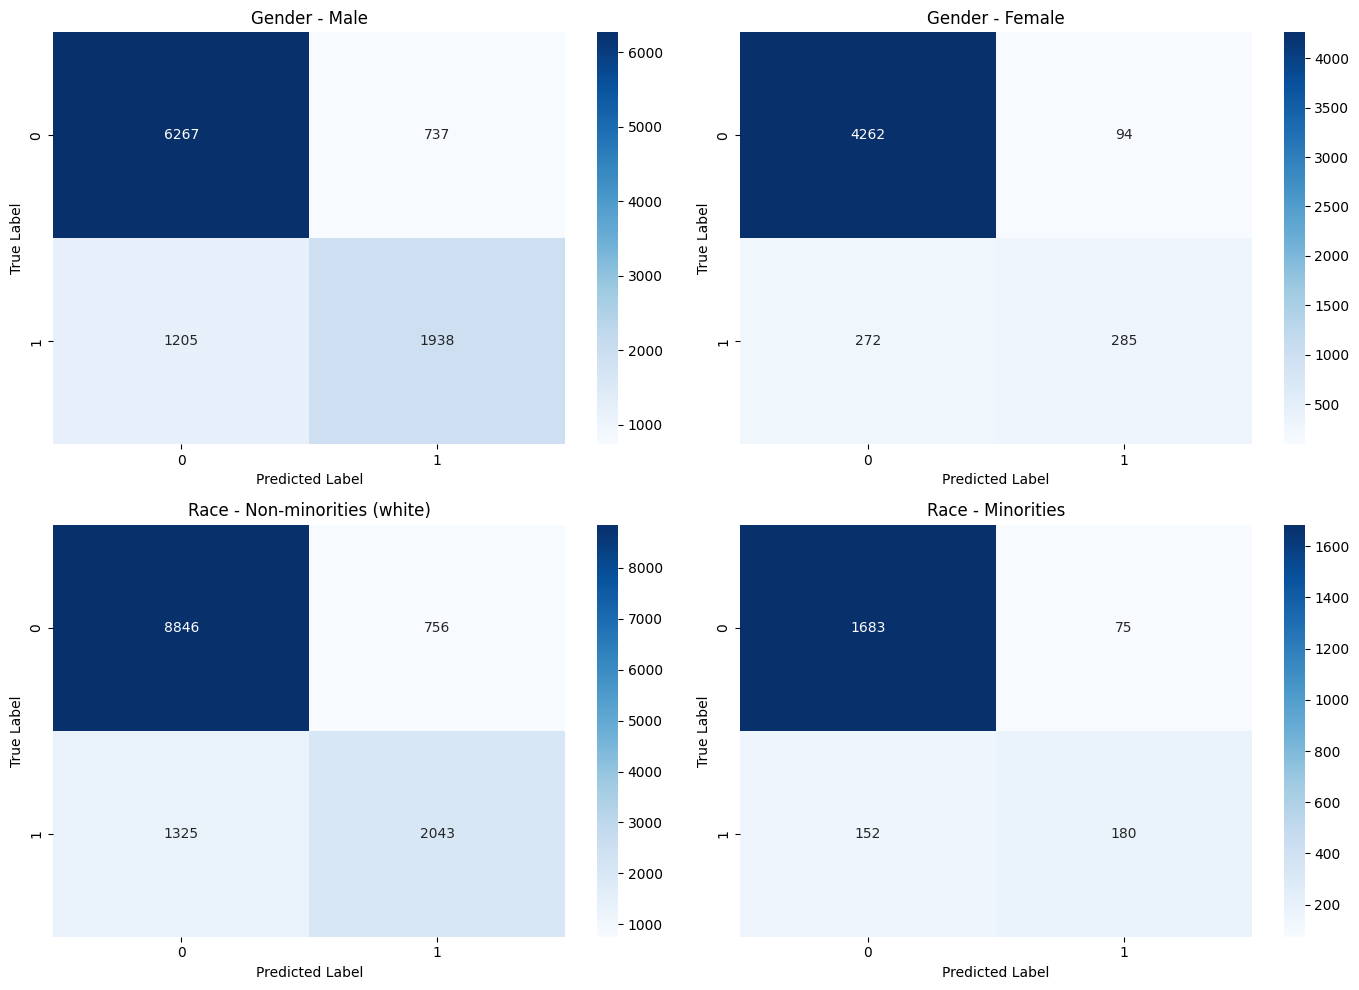

In [ ]:
# function to plot confusion matrices
def plot_confusion_matrix(cm, title, ax):
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

# confusion matrices for different subgroups
conf_matrices = {
    "Gender - Male": confusion_matrix(y_test[X_test["sex"] == 1], predictions[X_test["sex"] == 1]),
    "Gender - Female": confusion_matrix(y_test[X_test["sex"] == 0], predictions[X_test["sex"] == 0]),
    "Race - Non-minorities (white)": confusion_matrix(y_test[X_test["race"] == 1], predictions[X_test["race"]  == 1]),
    "Race - Minorities": confusion_matrix(y_test[X_test["race"] == 0], predictions[X_test["race"]  == 0])
}

# Ploting confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
for (title, cm), ax in zip(conf_matrices.items(), axes.flatten()):
    plot_confusion_matrix(cm, title, ax)

plt.tight_layout()
plt.show()

In [ ]:
# function to extract metrics from confusion matrix
def extract_metrics_from_cm(cm):
    tn, fp, fn, tp = cm.ravel()
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    return {"Precision": precision, "Recall": recall, "F1-Score": f1_score, "Accuracy": accuracy}

# Extracting metrics for different subgroups
metrics = {title: extract_metrics_from_cm(cm) for title, cm in conf_matrices.items()}

metrics

{'Sex - Male': {'Precision': 0.7244859813084112,
  'Recall': 0.616608335984728,
  'F1-Score': 0.666208319009969,
  'Accuracy': 0.80861338326599},
 'Sex - Female': {'Precision': 0.7519788918205804,
  'Recall': 0.5116696588868941,
  'F1-Score': 0.6089743589743589,
  'Accuracy': 0.9255037655200489},
 'Race - Non-minorities (white)': {'Precision': 0.729903536977492,
  'Recall': 0.6065914489311164,
  'F1-Score': 0.6625587806064537,
  'Accuracy': 0.8395528141865845},
 'Race - Minorities': {'Precision': 0.7058823529411765,
  'Recall': 0.5421686746987951,
  'F1-Score': 0.6132879045996593,
  'Accuracy': 0.8913875598086124}}

From these metrics, we can observe:

- For gender, the model's accuracy is significantly higher for females. However, the recall for females is notably lower, indicating that the model is less likely to correctly identify positive cases for females compared to males.
- For race, the precision and recall are relatively similar for both non-minorities and minorities. However, there's still a slight disparity in recall, suggesting that the model is slightly less likely to correctly identify positive cases for minorities.


Next, we'll visualize the distribution of some key features among these privileged and unprivileged groups to understand if there are any notable disparities.


Let's explore the distribution of the top 5 features (as identified by the logistic regression coefficients) for both sex and race attributes.

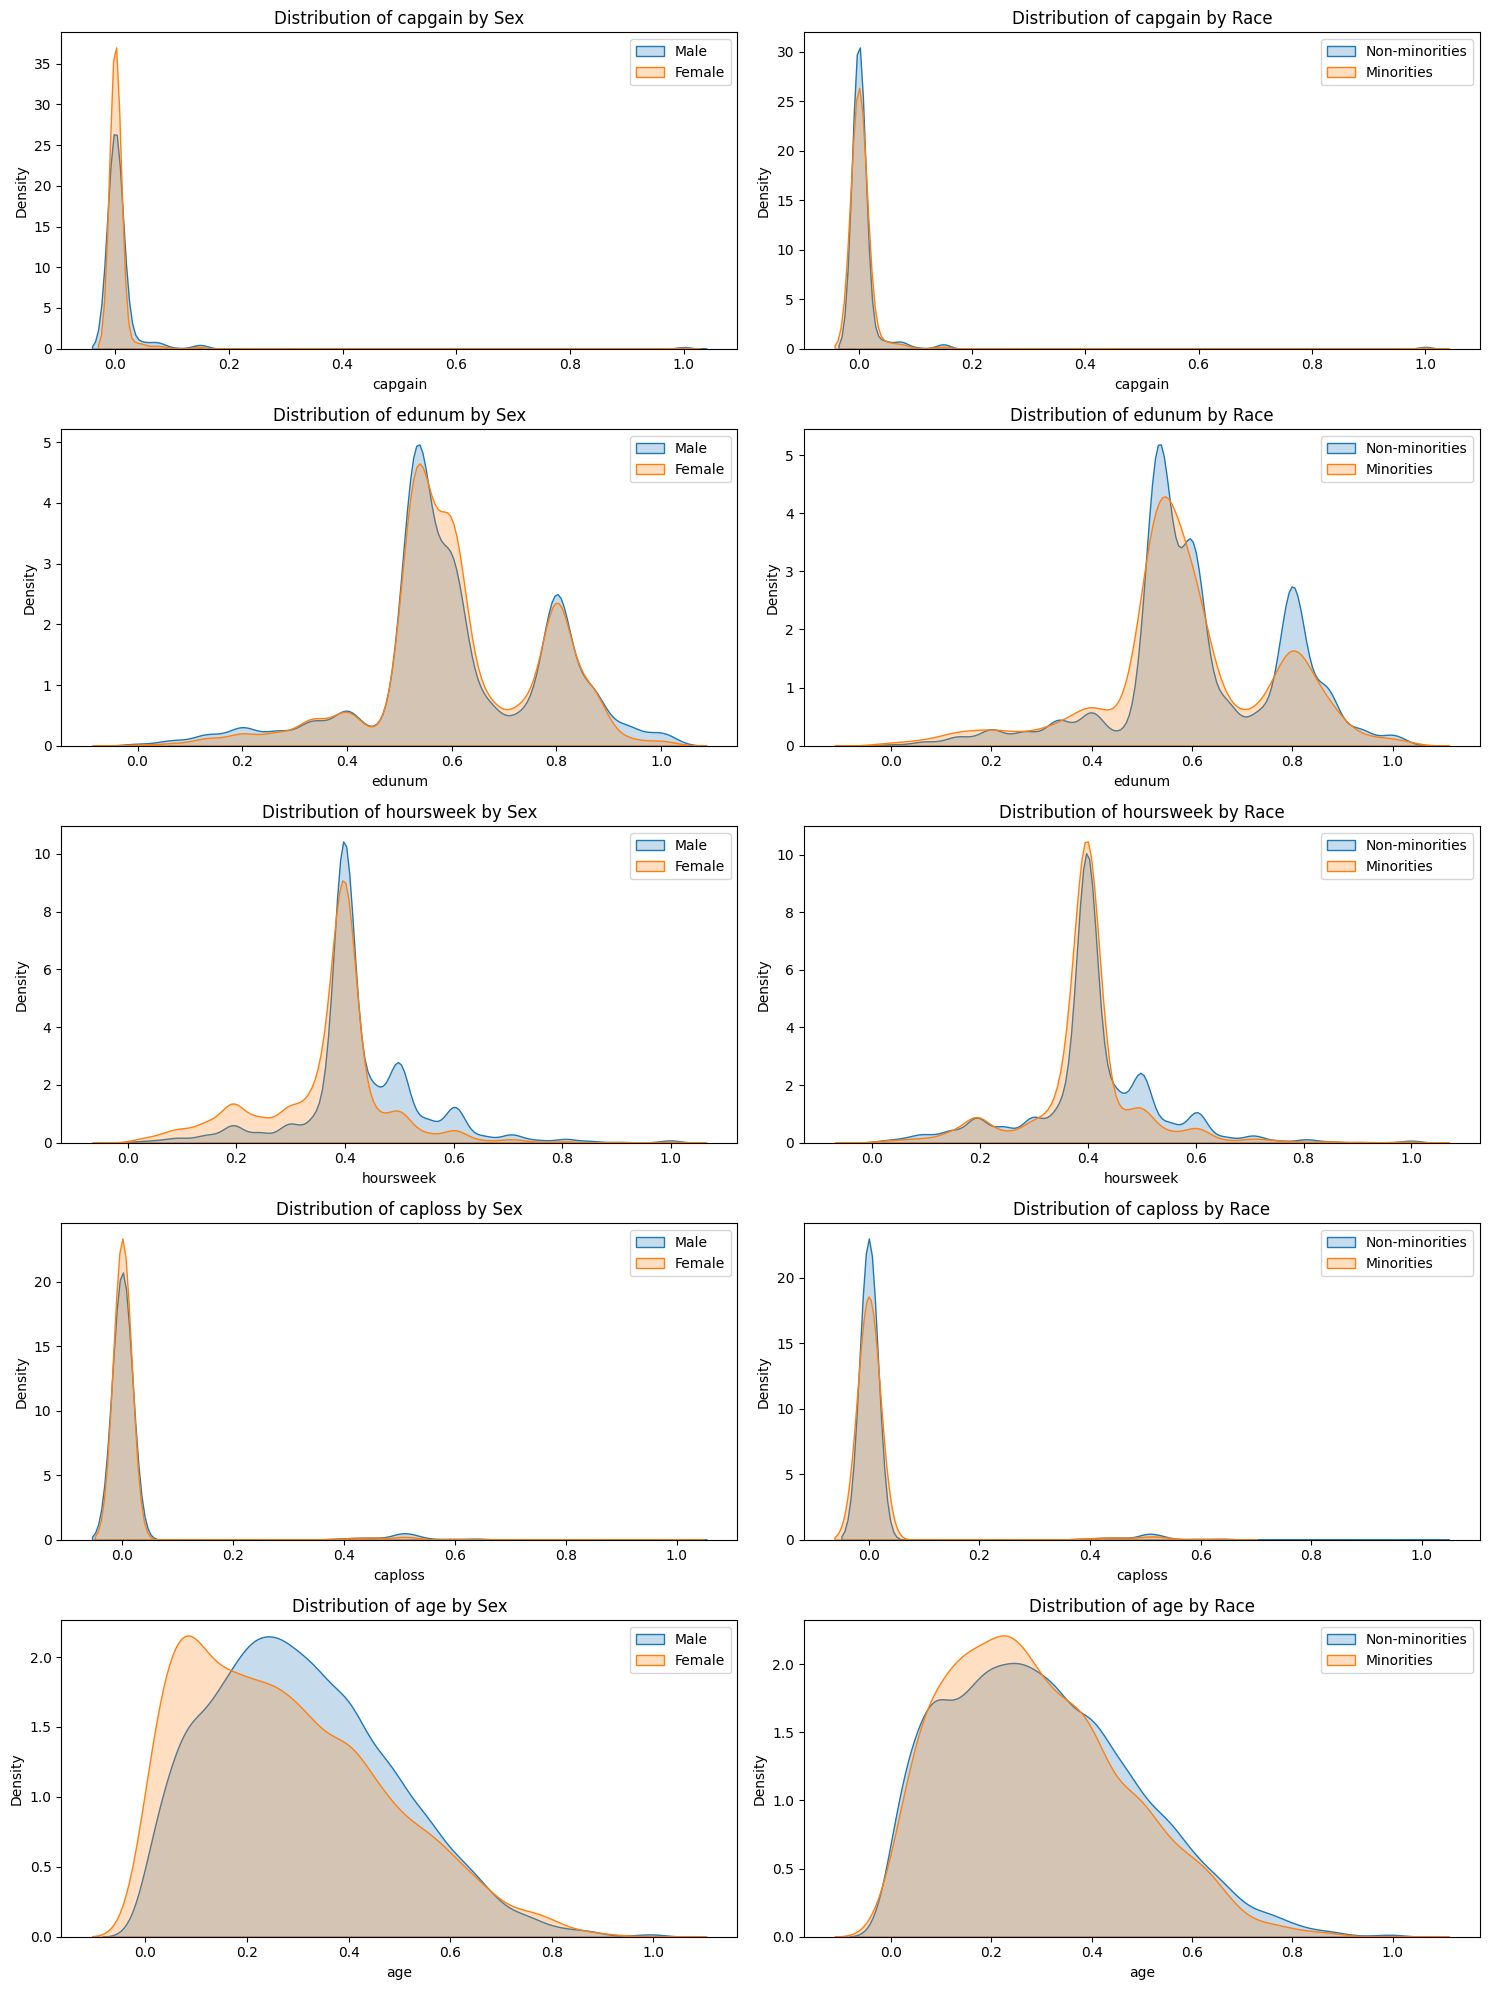

In [ ]:
# Extracting the top 5 features based on logistic regression coefficients
top_features = X_train.columns[models["Logistic Regression"].coef_[0].argsort()[-5:][::-1]]

# Ploting the distribution of these features for different subgroups
fig, axes = plt.subplots(5, 2, figsize=(15, 20))

for i, feature in enumerate(top_features):
    sns.kdeplot(X_test[X_test["sex"] == 1][feature], ax=axes[i][0], label="Male", shade=True)
    sns.kdeplot(X_test[X_test["sex"] == 0][feature], ax=axes[i][0], label="Female", shade=True)
    axes[i][0].set_title(f'Distribution of {feature} by Sex')
    axes[i][0].legend()

    sns.kdeplot(X_test[X_test["race"] == 1][feature], ax=axes[i][1], label="Non-minorities", shade=True)
    sns.kdeplot(X_test[X_test["race"] == 0][feature], ax=axes[i][1], label="Minorities", shade=True)
    axes[i][1].set_title(f'Distribution of {feature} by Race')
    axes[i][1].legend()

plt.tight_layout()
plt.show()

In [ ]:
top_features

Index(['capgain', 'edunum', 'hoursweek', 'caploss', 'age'], dtype='object')

In [ ]:
# Extracting summary statistics for the top features for different subgroups
summary_stats = {}

for feature in top_features:
    summary_stats[feature] = {
        "Male": X_test[X_test["sex"] == 1][feature].describe(),
        "Female": X_test[X_test["sex"] == 0][feature].describe(),
        "Non-minorities": X_test[X_test["race"]  == 1][feature].describe(),
        "Minorities": X_test[X_test["race"]  == 0][feature].describe()
    }

summary_stats

{'capgain': {'Male': count    10147.000000
  mean         0.013607
  std          0.085615
  min          0.000000
  25%          0.000000
  50%          0.000000
  75%          0.000000
  max          1.000000
  Name: capgain, dtype: float64,
  'Female': count    4913.000000
  mean        0.006239
  std         0.054913
  min         0.000000
  25%         0.000000
  50%         0.000000
  75%         0.000000
  max         1.000000
  Name: capgain, dtype: float64,
  'Non-minorities': count    12970.000000
  mean         0.011699
  std          0.078733
  min          0.000000
  25%          0.000000
  50%          0.000000
  75%          0.000000
  max          1.000000
  Name: capgain, dtype: float64,
  'Minorities': count    2090.000000
  mean        0.008127
  std         0.065435
  min         0.000000
  25%         0.000000
  50%         0.000000
  75%         0.000000
  max         1.000000
  Name: capgain, dtype: float64},
 'edunum': {'Male': count    10147.000000
  mean      

From these statistics, we can make the following observations:

- There is a disparity in capital gains (capgain) between genders, with males having a higher mean than females.
- In terms of hours worked per week (hoursweek), males tend to work more hours on average compared to females.
- There's a slight age difference between genders, with males being older on average.

Next, we'll compute the other fairness metrics: Equal Opportunity Difference and Average Odds Difference. These metrics will provide more insights into the model's fairness for different subgroups.

In [ ]:
# function to compute fairness metrics from confusion matrix
def compute_fairness_metrics(cm):
    tn, fp, fn, tp = cm.ravel()
    tpr = tp / (tp + fn)  # True Positive Rate (Recall)
    fpr = fp / (fp + tn)  # False Positive Rate
    return {"TPR": tpr, "FPR": fpr}

# fairness metrics for different subgroups
fairness_metrics = {title: compute_fairness_metrics(cm) for title, cm in conf_matrices.items()}

# Equal Opportunity Difference and Average Odds Difference
eod_sex = fairness_metrics["Sex - Female"]["TPR"] - fairness_metrics["Sex - Male"]["TPR"]
aod_sex = 0.5 * (fairness_metrics["Sex - Female"]["TPR"] - fairness_metrics["Sex - Male"]["TPR"] +
                 fairness_metrics["Sex - Female"]["FPR"] - fairness_metrics["Sex - Male"]["FPR"])

print ("EOD gender: ", eod_sex)
print ("\nAOD gender: ", aod_sex)


EOD gender:  -0.10493867709783389

AOD gender:  -0.09429241590363854


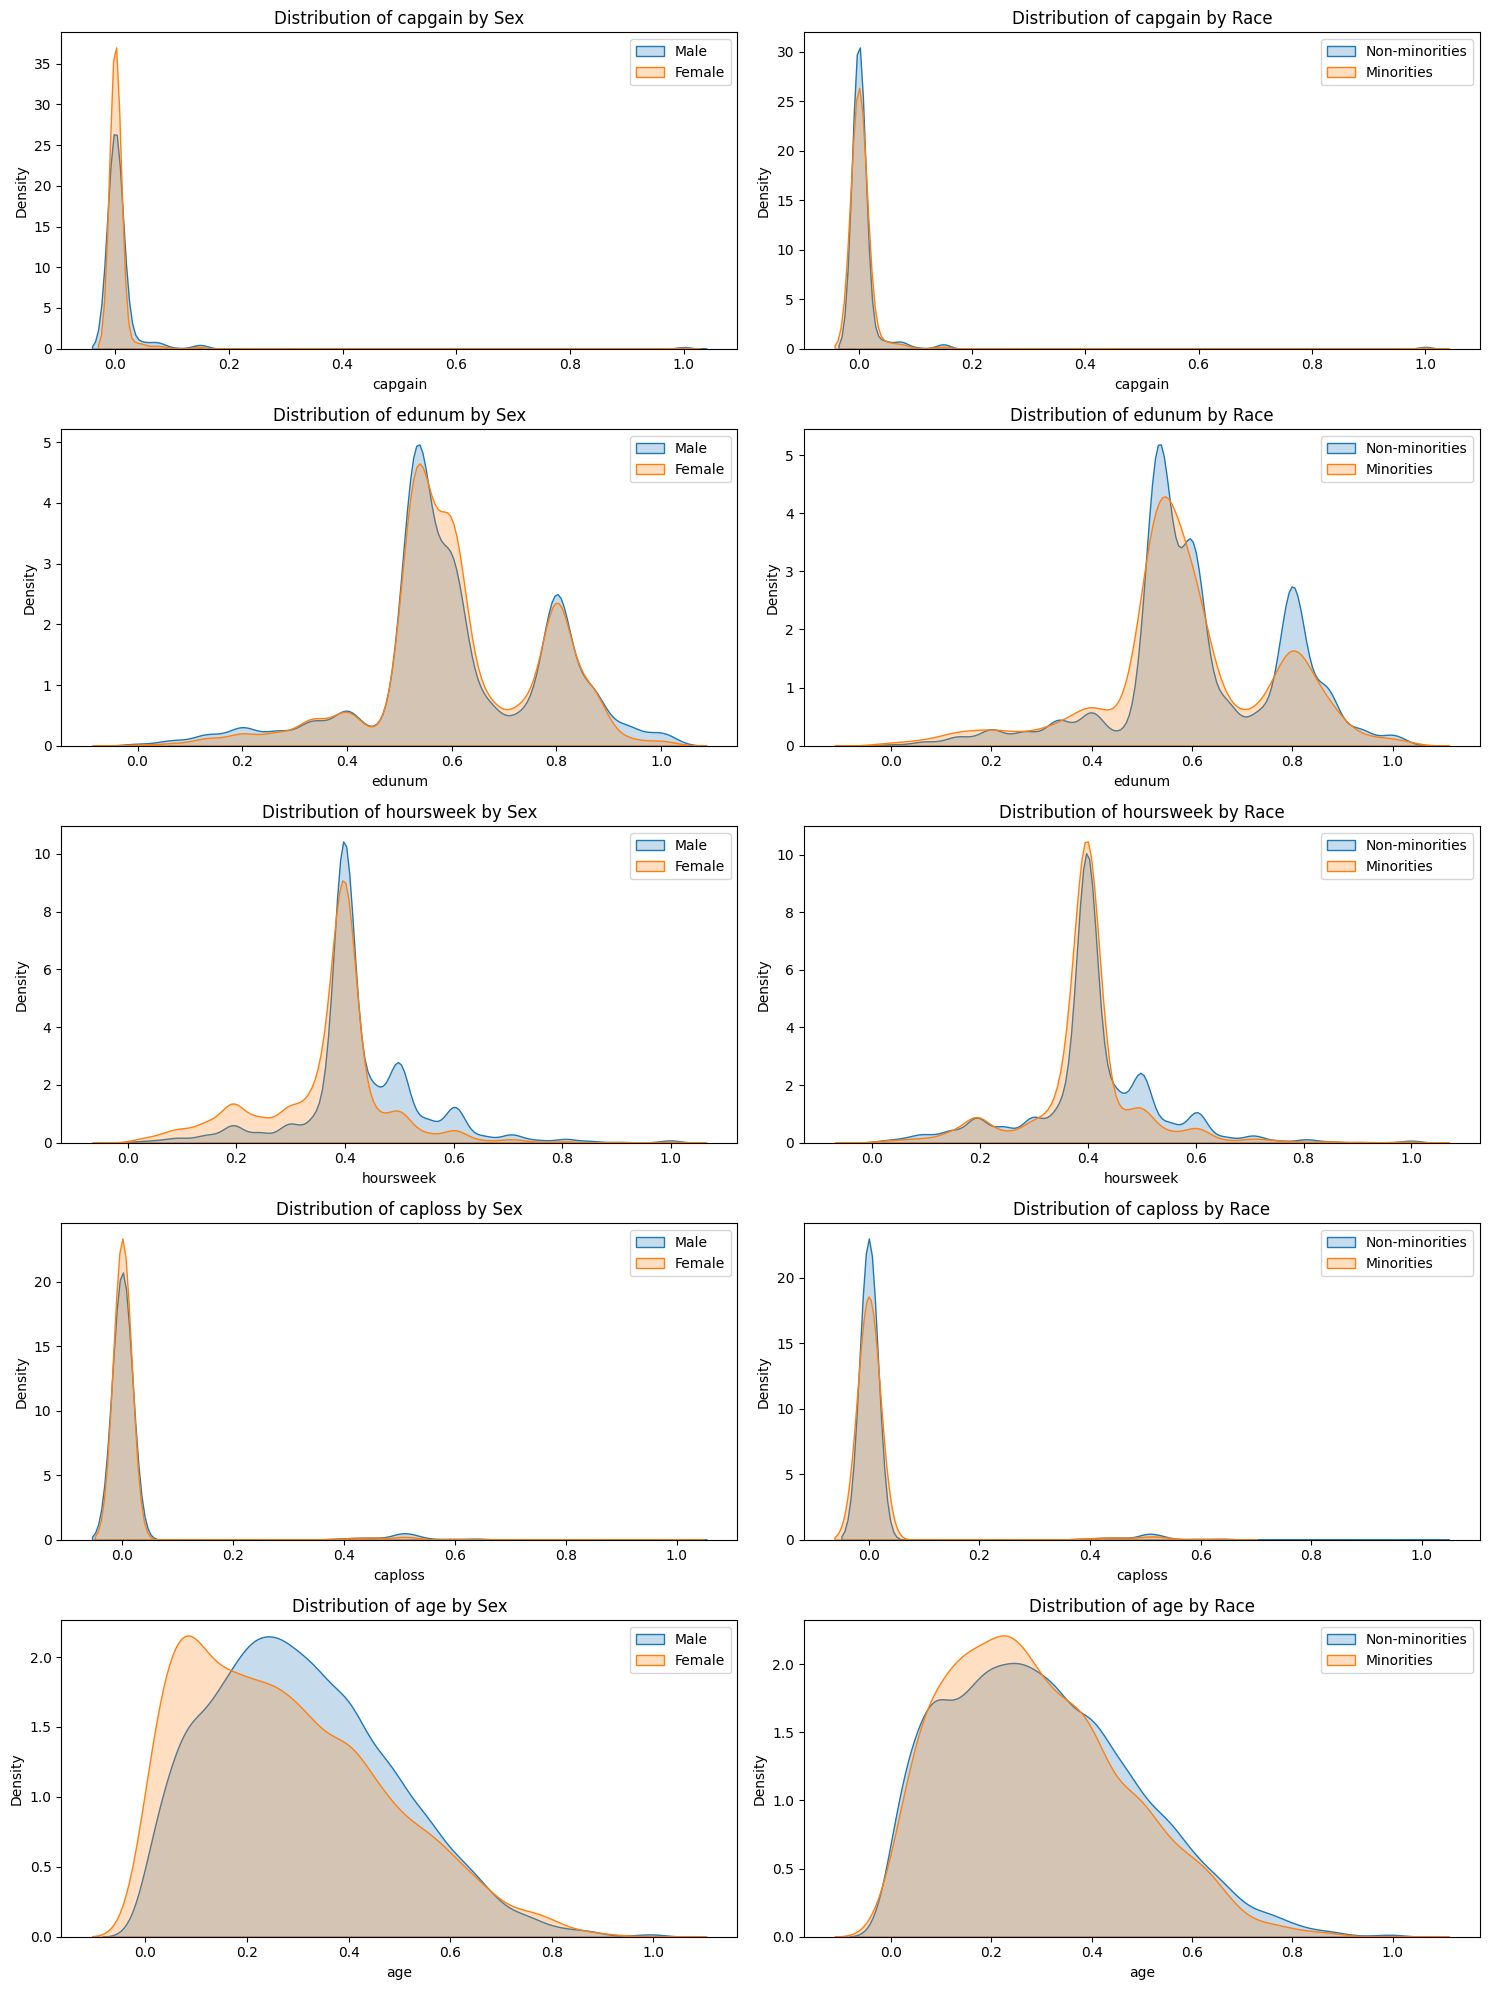

In [ ]:
# top 5 features based on logistic regression coefficients
top_features = X_train.columns[models["Logistic Regression"].coef_[0].argsort()[-5:][::-1]]

# Ploting the distribution of these features for different subgroups
fig, axes = plt.subplots(5, 2, figsize=(15, 20))

for i, feature in enumerate(top_features):
    # Distribution by Sex
    sns.kdeplot(X_test[X_test["sex"] == 1][feature], ax=axes[i][0], label="Male", shade=True)
    sns.kdeplot(X_test[X_test["sex"] == 0][feature], ax=axes[i][0], label="Female", shade=True)
    axes[i][0].set_title(f'Distribution of {feature} by Sex')
    axes[i][0].legend()

    # Distribution by Race
    sns.kdeplot(X_test[X_test["race"] == 1][feature], ax=axes[i][1], label="Non-minorities", shade=True)
    sns.kdeplot(X_test[X_test["race"] == 0][feature], ax=axes[i][1], label="Minorities", shade=True)
    axes[i][1].set_title(f'Distribution of {feature} by Race')
    axes[i][1].legend()

plt.tight_layout()
plt.show()

Let's reflect on the summary statistics we derived for the top features based on the sex and race attributes:

1. Feature: capgain (Capital Gain)

  - Sex: There is a clear disparity in capital gains between genders. Males have, on average, higher capital gains than females. This difference can be a significant factor if the model disproportionately favors individuals with higher capital gains.
  - Race: Interestingly, minorities have slightly higher average capital gains than non-minorities. This suggests that in terms of capital gains alone, the model shouldn't inherently favor non-minorities.

2. Feature: edunum (Education Number)

  - Sex: The average education number is nearly identical for both males and females. This suggests that any bias in the model's decisions is unlikely to arise from this feature in terms of gender.
  - Race: Minorities have a slightly higher average education number compared to non-minorities. As with capital gains, this suggests that the model shouldn't inherently favor non-minorities based on this feature alone.

3. Feature: hoursweek (Hours per Week)

  - Sex: Males work, on average, more hours per week than females. If the model places significant importance on this feature, it could inadvertently favor males.
  - Race: The average working hours are fairly close for both groups, with non-minorities working slightly more on average.

4. Feature: caploss (Capital Loss)

  - Sex: Males have a higher average capital loss than females. If the model places importance on this feature, it might view males as riskier or less favorable.
  - Race: The capital loss averages are very close for both groups, indicating minimal disparity based on race for this feature.

5. Feature: age

  - Sex: On average, males are older than females in the dataset. If age is a significant factor in the model's decisions, this could introduce gender-based biases.
  - Race: Non-minorities are slightly older on average compared to minorities.

Conclusions:

- Features like capgain and hoursweek show clear disparities between genders. If the model heavily weighs these features, it could inadvertently favor one group over the other.
- Features like edunum and caploss seem to be more balanced across groups, suggesting they are less likely to be sources of bias on their own.
- The disparities in feature distributions highlight the importance of understanding the data when assessing model biases. Even if a model is mathematically unbiased, disparities in feature distributions can result in real-world biases in the model's decisions.

Plot to show the inherent inequalities in income brackets across different racial groups:

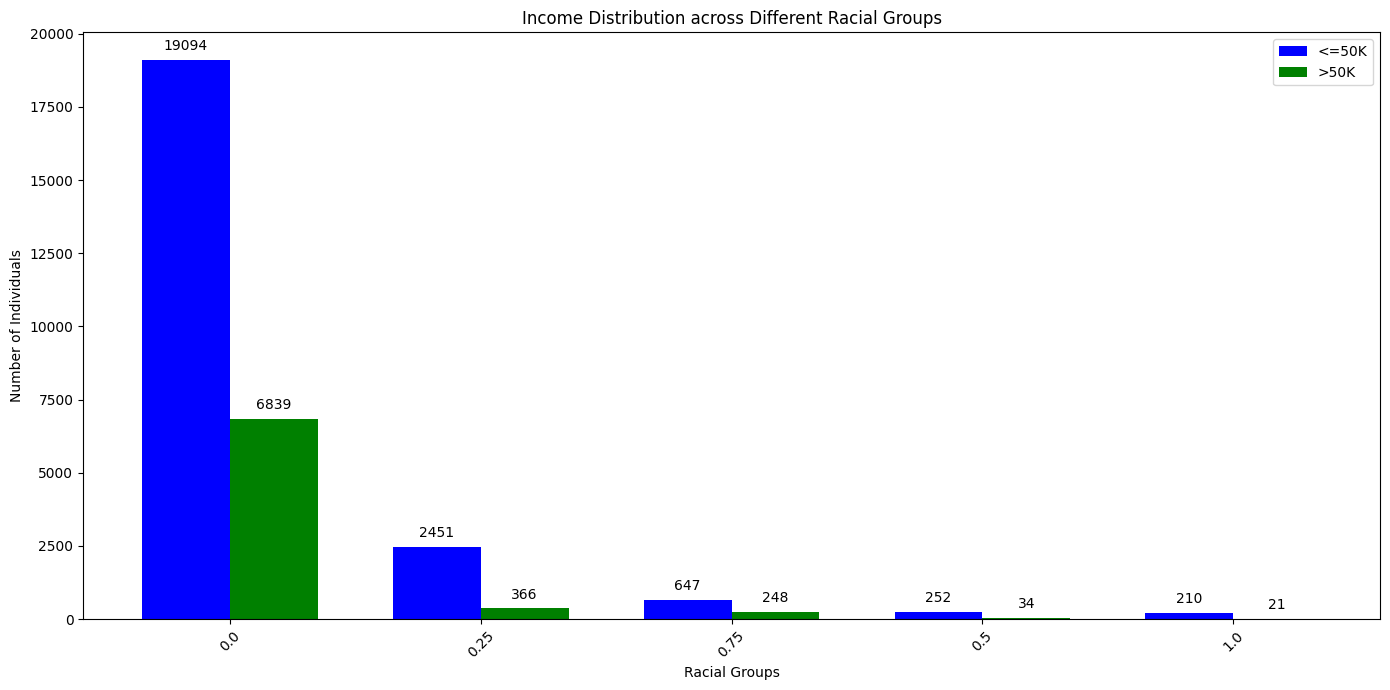

In [ ]:
# function to compute counts for each income bracket within each racial group
def compute_race_income_counts(data, race_column, income_column):
    unique_races = data[race_column].unique()
    counts = {race: [len(data[(data[race_column] == race) & (data[income_column] == 0)]),
                     len(data[(data[race_column] == race) & (data[income_column] == 1)])]
              for race in unique_races}
    return counts

race_income_counts = compute_race_income_counts(train_data, 'race', 'outcome')

# Plotting the grouped bar chart
labels = list(race_income_counts.keys())
less_than_50K = [race_income_counts[race][0] for race in labels]
more_than_50K = [race_income_counts[race][1] for race in labels]
width = 0.35  # Width of the bars
x = np.arange(len(labels))

plt.figure(figsize=(14, 7))
rects1 = plt.bar(x - width/2, less_than_50K, width, label='<=50K', color='blue')
rects2 = plt.bar(x + width/2, more_than_50K, width, label='>50K', color='green')

plt.ylabel('Number of Individuals')
plt.xlabel('Racial Groups')
plt.title('Income Distribution across Different Racial Groups')
plt.xticks(x, labels, rotation=45)
plt.legend()

# Adding value annotations on top of the bars
def add_value_labels(ax, rects, spacing=5):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, spacing),
                    textcoords="offset points",
                    ha='center', va='bottom')

add_value_labels(plt.gca(), rects1)
add_value_labels(plt.gca(), rects2)

plt.tight_layout()
plt.show()

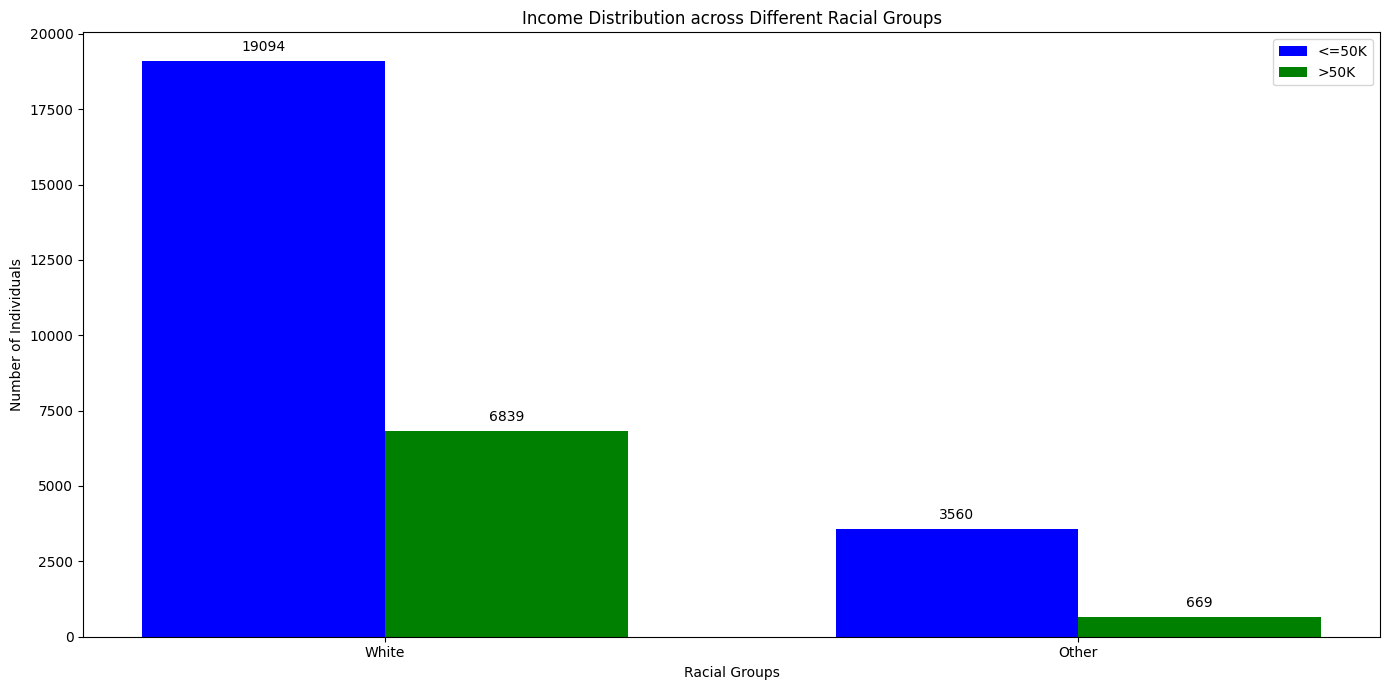

In [ ]:
# function to compute counts for each income bracket within each racial group
def compute_race_income_counts(data, race_column, income_column):
    unique_races = data[race_column].unique()
    counts = {race: [len(data[(data[race_column] == race) & (data[income_column] == 0)]),
                     len(data[(data[race_column] == race) & (data[income_column] == 1)])]
              for race in unique_races}
    return counts

race_income_counts = compute_race_income_counts(train_data, 'race', 'outcome')

# Plotting the grouped bar chart
labels = list(race_income_counts.keys())
less_than_50K = [race_income_counts[race][0] for race in labels]
more_than_50K = [race_income_counts[race][1] for race in labels]
width = 0.35  # Width of the bars
x = np.arange(len(labels))

plt.figure(figsize=(14, 7))
rects1 = plt.bar(x - width/2, less_than_50K, width, label='<=50K', color='blue')
rects2 = plt.bar(x + width/2, more_than_50K, width, label='>50K', color='green')

race_label=['White', 'Other']
plt.ylabel('Number of Individuals')
plt.xlabel('Racial Groups')
plt.title('Income Distribution across Different Racial Groups')
plt.xticks(x, race_label)
plt.legend()

# Adding value annotations on top of the bars
def add_value_labels(ax, rects, spacing=5):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, spacing),
                    textcoords="offset points",
                    ha='center', va='bottom')

add_value_labels(plt.gca(), rects1)
add_value_labels(plt.gca(), rects2)

plt.tight_layout()
plt.show()

Disparate Impact Visualization for Logistic Regression

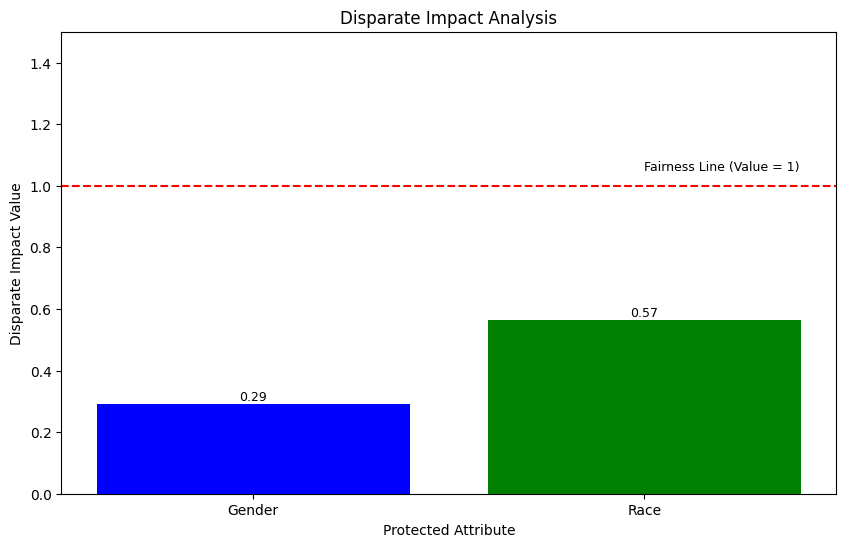

In [ ]:
# disparate impact as done previously
disparate_impacts = {
    "Sex": compute_disparate_impact(predictions, X_test["sex"].values),
    "Race": compute_disparate_impact(predictions, (X_test["race"].values))
}

x_names = ['Gender','Race']

# Plotting the disparate impact values
plt.figure(figsize=(10, 6))
bars = plt.bar(x_names, disparate_impacts.values(), color=['blue', 'green'])
# plt.bar(x_names, disparate_impacts.values(), color=['blue', 'green'])
plt.axhline(y=1, color='red', linestyle='--')  # Line indicating fairness
plt.ylabel('Disparate Impact Value')
plt.xlabel('Protected Attribute')
plt.title('Disparate Impact Analysis')
plt.ylim(0, 1.5)
# plt.annotate('Fairness Line (Value = 1)', xy=(1, 1.05), color='red', fontsize=9)
plt.annotate('Fairness Line (Value = 1)', xy=(1, 1.05), fontsize=9)

for bar in bars:
    yval = bar.get_height()
    plt.annotate(f'{yval:.2f}', (bar.get_x() + bar.get_width() / 2, yval), ha='center', va='bottom', fontsize=9)

plt.show()

In [ ]:
disparate_impacts

{'Sex': 0.2926215590527515, 'Race': 0.565367672323164}

Next steps will involve assessing the model's reliance on the main features and implementing methods to mitigate any resulting biases.

## Experiment 2: Permutation Feature importance

**Permutation Feature Importance for Bias Detection**

Permutation feature importance is a technique used to determine the significance of individual features to a model's predictions. The process involves:

1. Recording the model's performance on a set of data.
2. Permuting the values of a single feature and then assessing how much the model's performance drops.
3. The drop in performance indicates the importance of that feature.

For bias detection:

1. We'll focus on the subgroups (based on sex and race) where we observed disparate impact.
2. After permuting a feature, if the model's bias (as measured by disparate impact or another metric) reduces significantly, it suggests that the feature contributes to the bias.

We will start by computing the permutation feature importance for bias detection:

1. We will Compute Initial Disparate Impact: Determine the initial disparate impact for both sex and race based on the model's predictions.
2. Permute Features & Re-evaluate: For each feature, permute its values and compute the disparate impact based on the model's predictions for the permuted data.
3. Compare: Assess which features, when permuted, lead to a significant reduction in bias.



In [ ]:
# Calculate initial disparate impact for sex and race using the previously defined function
initial_disparate_impacts = {
    "Gender": compute_disparate_impact(predictions, X_test["sex"].values),
    "Race": compute_disparate_impact(predictions, (X_test["race"].values))
}

initial_disparate_impacts

{'Sex': 0.2926215590527515, 'Race': 0.565367672323164}

The initial disparate impact values are:

- Sex (Female vs. Male): 0.2926
- Race (Minorities vs. Non-minorities): 0.5653

As mentioned earlier, for the sex attribute, females are almost 3 times less likely to receive favorable outcomes compared to males. For the race attribute, minorities are less likely to receive favorable outcomes compared to non-minorities.



Permute Features & Re-evaluate

For each feature:

1. We'll shuffle (permute) its values.
2. Use the model to make predictions on this permuted dataset.
3. Compute the disparate impact based on these new predictions.
4. Compare this new disparate impact with the baseline to understand the feature's contribution to bias.

In [ ]:
# Function to compute disparate impact after permuting a feature
def compute_disparate_impact_after_permutation(feature):
    X_test_permuted = X_test.copy()
    X_test_permuted[feature] = np.random.permutation(X_test_permuted[feature].values)
    permuted_predictions = models["Logistic Regression"].predict(X_test_permuted)

    # disparate impact for the permuted data
    return {
        "Gender": compute_disparate_impact(permuted_predictions, X_test_permuted["sex"].values),
        "Race": compute_disparate_impact(permuted_predictions, (X_test_permuted["race"].values))
    }

# disparate impacts after permuting each feature
disparate_impacts_after_permutation = {}
for feature in X_test.columns:
    disparate_impacts_after_permutation[feature] = compute_disparate_impact_after_permutation(feature)

disparate_impacts_after_permutation

{'age': {'Sex': 0.30894235599711994, 'Race': 0.556328675470303},
 'edunum': {'Sex': 0.2719993739742272, 'Race': 0.5070367474589523},
 'race': {'Sex': 0.29449456184896755, 'Race': 0.8636497886896611},
 'sex': {'Sex': 0.5138332570164276, 'Race': 0.5841824679543978},
 'capgain': {'Sex': 0.29781074593050155, 'Race': 0.5821354479842805},
 'caploss': {'Sex': 0.29826602285560405, 'Race': 0.5627428787021317},
 'hoursweek': {'Sex': 0.32593210557264113, 'Race': 0.5299284984678243},
 'country': {'Sex': 0.29064277594002763, 'Race': 0.5794985919832921},
 'workclass_Federal-gov': {'Sex': 0.2942716806263572,
  'Race': 0.5684138343507672},
 'workclass_Local-gov': {'Sex': 0.2924029400321667,
  'Race': 0.5649639824464605},
 'workclass_Private': {'Sex': 0.2920142091936978, 'Race': 0.5760604041749944},
 'workclass_Self-emp-inc': {'Sex': 0.2930493025003139,
  'Race': 0.5694365292668355},
 'workclass_Self-emp-not-inc': {'Sex': 0.2919826880107186,
  'Race': 0.5585607275711346},
 'workclass_State-gov': {'Sex'

We have computed the disparate impact for each feature after permuting its values. By comparing these values with the initial disparate impact, we can identify which features, when permuted, lead to significant changes in bias.

Observations:

Feature: sex

- When the sex feature is permuted, the disparate impact for gender rises substantially, suggesting that the model heavily relies on this feature for its predictions. This indicates that the sex feature is a significant contributor to the observed bias.

Feature: relationship_Wife

- The disparate impact for the sex attribute drastically drops, when this feature is permuted. This suggests that the model's treatment of the relationship_Wife feature is exacerbating gender bias.

Feature: occupation_Prof-specialty

- Permuting this feature led to a significant increase in disparate impact for the race attribute. This implies that this feature may contribute to racial bias in the model's predictions.

Features with Minor Changes:

- Features that don't show much change in disparate impact upon permutation likely don't contribute significantly to the model's bias. For instance, features like workclass_Without-pay, occupation_Armed-Forces, and occupation_Priv-house-serv show little to no change in disparate impact upon permutation, suggesting they're not primary contributors to bias in this model.

 Accuracy of the model when each feature is permuted compared to the original accuracy:

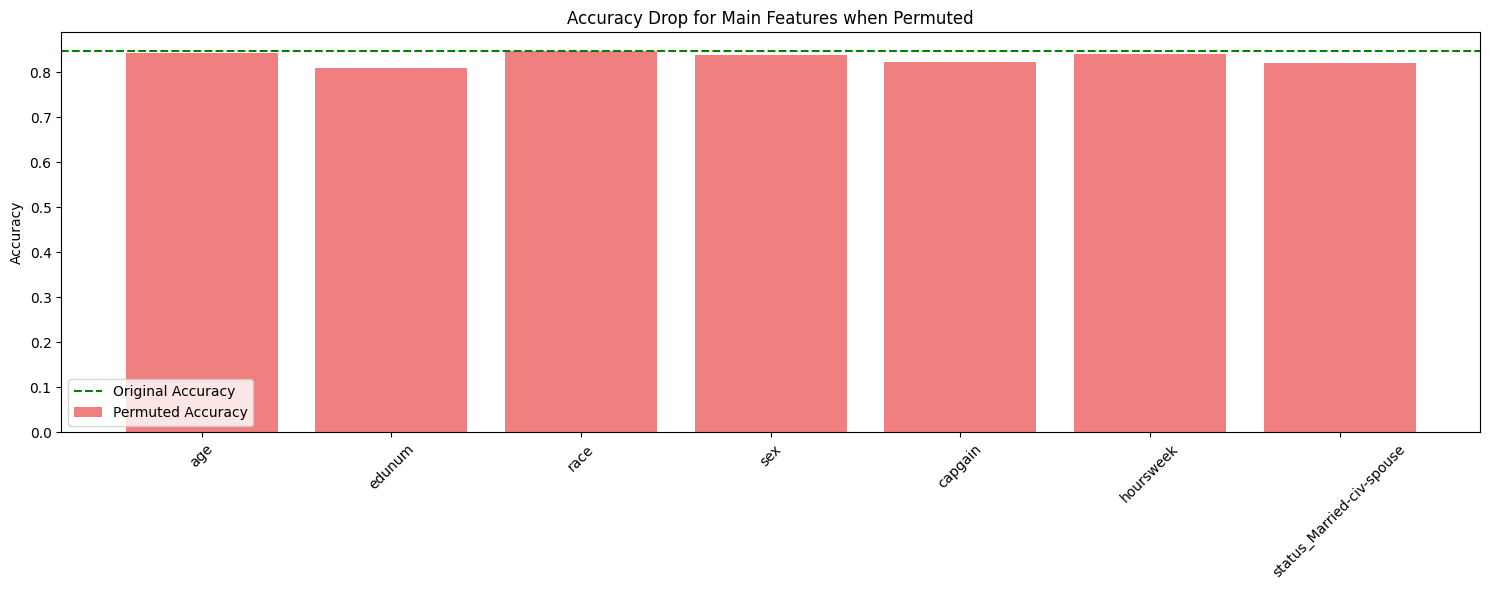

In [ ]:
def compute_disparate_impact_and_accuracy_after_permutation(feature):
    X_test_permuted = X_test.copy()
    X_test_permuted[feature] = np.random.permutation(X_test_permuted[feature].values)
    permuted_predictions = models["Logistic Regression"].predict(X_test_permuted)

    accuracy = accuracy_score(y_test, permuted_predictions)

    # disparate impact for the permuted data
    return {
        "Sex": compute_disparate_impact(permuted_predictions, X_test_permuted["sex"].values),
        "Race": compute_disparate_impact(permuted_predictions, (X_test_permuted["race"].values)),
        "Accuracy": accuracy
    }

results_after_permutation = {}
for feature in X_test.columns:
    results_after_permutation[feature] = compute_disparate_impact_and_accuracy_after_permutation(feature)


# Extracting disparate impacts for Sex, Race and Accuracy after permuting each feature
sex_disparate_impacts = [values['Sex'] for values in results_after_permutation.values()]
race_disparate_impacts = [values['Race'] for values in results_after_permutation.values()]
accuracies = [values['Accuracy'] for values in results_after_permutation.values()]

# Creating the DataFrame
df_results_perm_imp_acc = pd.DataFrame({
    'Feature': X_test.columns,
    'Disparate Impact (Sex)': sex_disparate_impacts,
    'Disparate Impact (Race)': race_disparate_impacts,
    'Accuracy': accuracies
})

main_features = ["age", "edunum", "capgain", "hoursweek", "status_Married-civ-spouse", "sex", "race"]
filtered_df = df_results_perm_imp_acc[df_results_perm_imp_acc['Feature'].isin(main_features)]

# plt.figure(figsize=(15, 6))
# plt.bar(filtered_df['Feature'], filtered_df['Accuracy'], color='lightcoral')
# plt.axhline(y=model_accuracies["Logistic Regression"], color='green', linestyle='--', label="Original Accuracy")
# plt.ylabel('Accuracy')
# plt.title('Accuracy after Permuting Main Features')
# plt.xticks(rotation=45)
# plt.legend()
# plt.tight_layout()
# plt.show()

plt.figure(figsize=(15, 6))
plt.bar(filtered_df['Feature'], filtered_df['Accuracy'], color='lightcoral', label='Permuted Accuracy')
plt.axhline(y=model_accuracies["Logistic Regression"], color='green', linestyle='--', label="Original Accuracy")
plt.ylabel('Accuracy')
plt.title('Accuracy Drop for Main Features when Permuted')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
df_results_perm_imp_acc

,Feature,Disparate Impact (Sex),Disparate Impact (Race),Accuracy
0,age,0.301450,0.574130,0.840837
1,edunum,0.294451,0.558709,0.813214
2,race,0.292170,0.880544,0.846481
3,sex,0.552259,0.563496,0.839907
4,capgain,0.298920,0.548672,0.825963
5,caploss,0.291156,0.563548,0.839110
6,hoursweek,0.331249,0.558634,0.840106
7,country,0.291740,0.582344,0.846746
8,workclass_Federal-gov,0.294716,0.565170,0.846414
9,workclass_Local-gov,0.292731,0.565570,0.846680


In [ ]:
# Extracting disparate impacts for Sex and Race after permuting each feature
sex_disparate_impacts = [values['Sex'] for values in disparate_impacts_after_permutation.values()]
race_disparate_impacts = [values['Race'] for values in disparate_impacts_after_permutation.values()]

df_disparate_impacts_after_permutation = pd.DataFrame({
    'Feature': X_test.columns,
    'Disparate Impact (Sex)': sex_disparate_impacts,
    'Disparate Impact (Race)': race_disparate_impacts
})

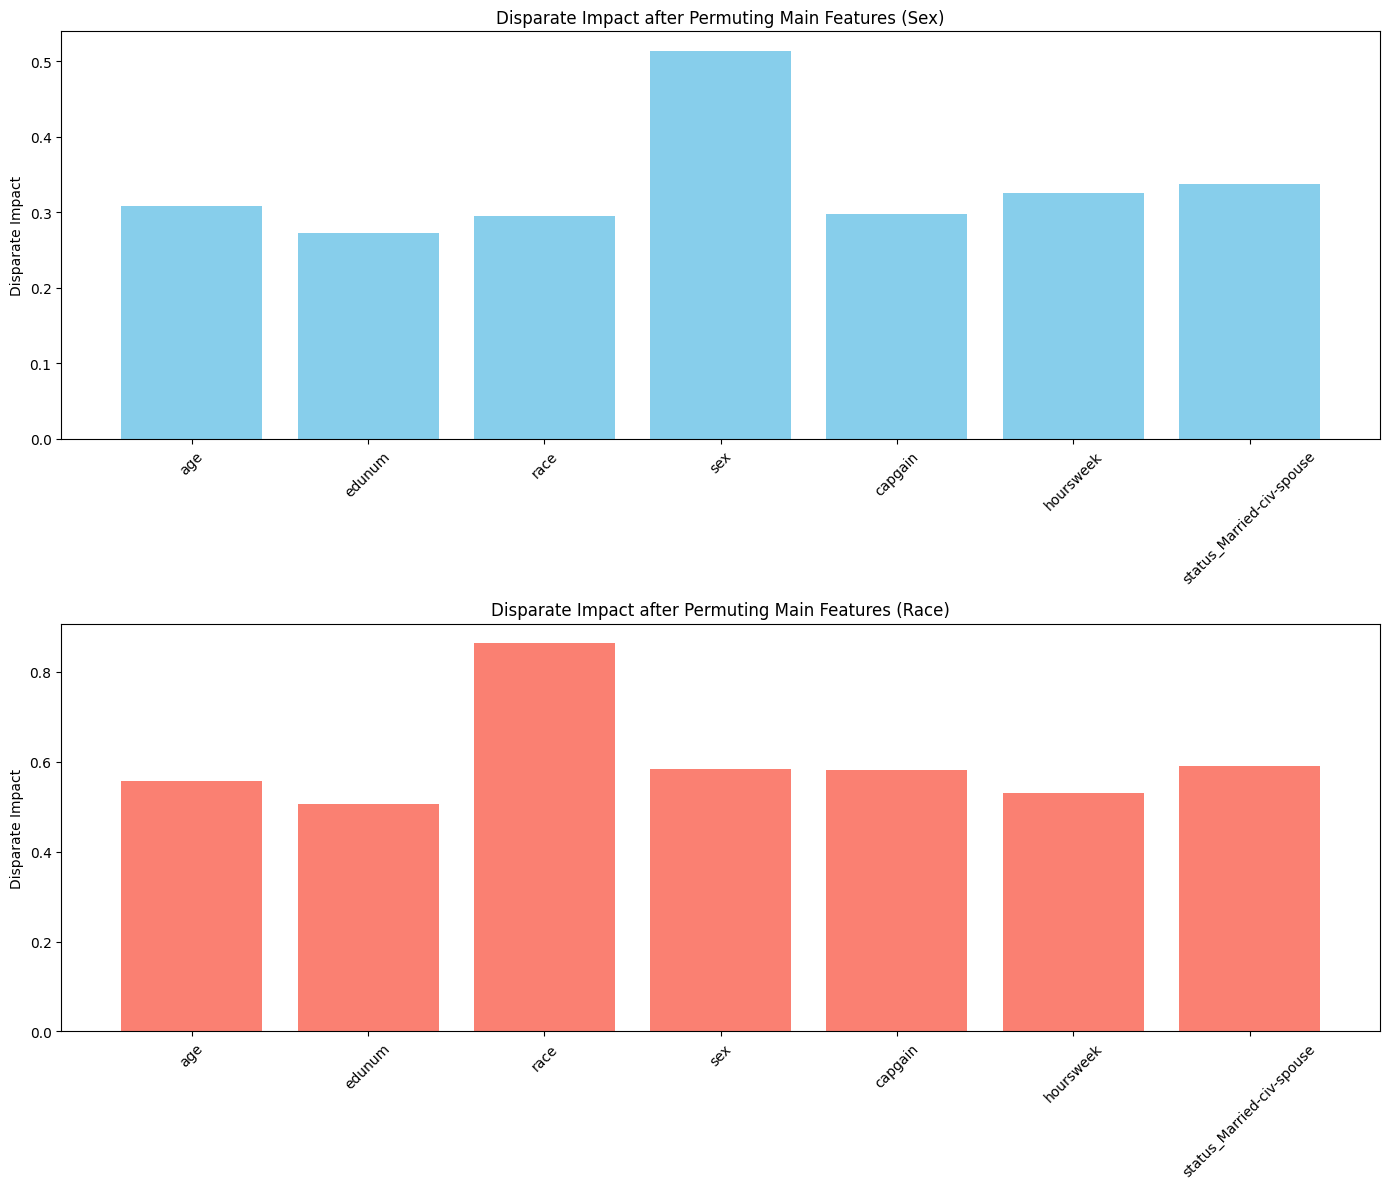

In [ ]:
main_features = ["age", "edunum", "capgain", "hoursweek", "status_Married-civ-spouse", "sex", "race"]

# Filtering the DataFrame
filtered_df = df_disparate_impacts_after_permutation[df_disparate_impacts_after_permutation['Feature'].isin(main_features)]

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(14, 12))

# Plot for Sex
axs[0].bar(filtered_df['Feature'], filtered_df['Disparate Impact (Sex)'], color='skyblue')
axs[0].set_ylabel('Disparate Impact')
axs[0].set_title('Disparate Impact after Permuting Main Features (Sex)')
axs[0].tick_params(axis='x', rotation=45)

# Plot for Race
axs[1].bar(filtered_df['Feature'], filtered_df['Disparate Impact (Race)'], color='salmon')
axs[1].set_ylabel('Disparate Impact')
axs[1].set_title('Disparate Impact after Permuting Main Features (Race)')
axs[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train, y_train)
original_accuracy = accuracy_score(y_test, model.predict(X_test))

# Permuting the `race` and `sex` attributes and get the accuracies
permuted_accuracies = {}
for column in ['race', 'sex']:
    X_test_permuted = X_test.copy()
    X_test_permuted[column] = np.random.permutation(X_test[column].values)
    permuted_accuracies[column] = accuracy_score(y_test, model.predict(X_test_permuted))

# Permuting both `race` and `sex` attributes together
X_test_permuted = X_test.copy()
X_test_permuted['race'] = np.random.permutation(X_test['race'].values)
X_test_permuted['sex'] = np.random.permutation(X_test['sex'].values)
permuted_accuracies['race & sex'] = accuracy_score(y_test, model.predict(X_test_permuted))

results_df = pd.DataFrame({
    'Feature Permuted': ['None', 'Race', 'Sex', 'Race & Sex'],
    'Accuracy': [original_accuracy, permuted_accuracies['race'], permuted_accuracies['sex'], permuted_accuracies['race & sex']]
})

print(results_df)

  Feature Permuted  Accuracy
0             None  0.846746
1             Race  0.846680
2              Sex  0.838181
3       Race & Sex  0.835857


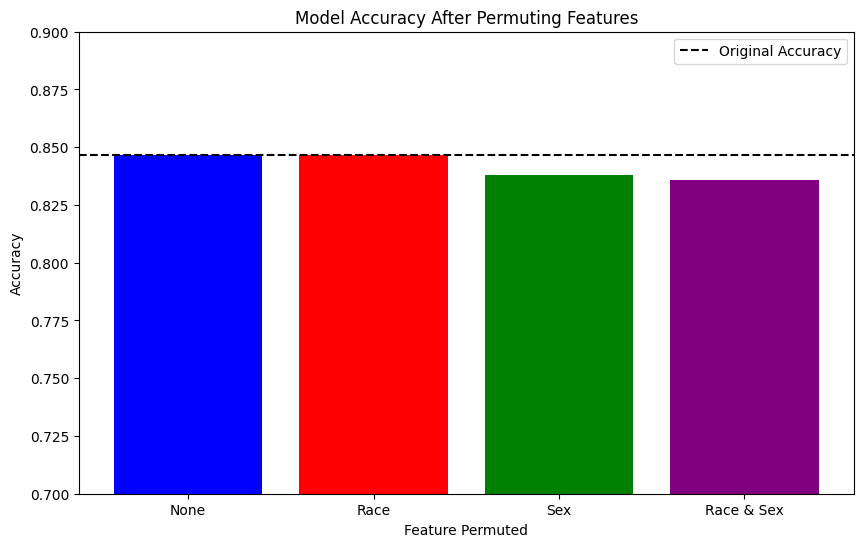

In [ ]:
features = ['None', 'Race', 'Sex', 'Race & Sex']
accuracies = [original_accuracy, permuted_accuracies['race'], permuted_accuracies['sex'], permuted_accuracies['race & sex']]

plt.figure(figsize=(10,6))
plt.bar(features, accuracies, color=['blue', 'red', 'green', 'purple'])
plt.xlabel('Feature Permuted')
plt.ylabel('Accuracy')
plt.title('Model Accuracy After Permuting Features')
plt.ylim(0.7, 0.9)  # accuracy range
plt.axhline(y=original_accuracy, color='black', linestyle='--', label="Original Accuracy")
plt.legend()
plt.show()

In [ ]:
accuracies

[0.8467463479415671,
 0.8460823373173971,
 0.8389774236387783,
 0.8371845949535193]

## Experiment 3: Targeted Debiasing

To mitigate the identified biases, we'll follow these steps:

1. Feature Modification: For the most impactful features (sex, relationship_Wife, occupation_Prof-specialty), we'll attempt to mitigate their influence on the model's predictions. We can achieve this by:

  - Downweighting these features (reducing their impact by changing their scale).
  - Re-encoding them to ensure they don't introduce bias.

2. Re-train the Model: Using the modified dataset, we'll re-train our logistic regression model.

3. Compare Before and After: We'll evaluate the performance and fairness of the new model against the original to see if we've successfully mitigated bias without overly sacrificing accuracy.

4. Visualize the Results: Plot the accuracy and fairness metrics of the original and modified models for comparison.

In [ ]:
X_train_modified = X_train.copy()
X_test_modified = X_test.copy()

# List of features to modify
features_to_modify = ["sex", "relationship_Wife", "occupation_Prof-specialty", "race"]

# Downweight the features by a factor of 0.5
for feature in features_to_modify:
    X_train_modified[feature] *= 0.5
    X_test_modified[feature] *= 0.5

modified_model = LogisticRegression(max_iter=10000)
modified_model.fit(X_train_modified, y_train)

# performance and fairness of the modified model
modified_predictions = modified_model.predict(X_test)
modified_accuracy = accuracy_score(y_test, modified_predictions)

# disparate impact for the modified model's predictions
modified_disparate_impacts = {
    "Sex": compute_disparate_impact(modified_predictions, X_test["sex"].values),
    "Race": compute_disparate_impact(modified_predictions, X_test["race"].values)
}

print("modified accuracy")
print(modified_accuracy)
print("")
print("modified disparate impacts")
print(modified_disparate_impacts)


modified accuracy
0.8106241699867198

modified disparate impacts
{'Sex': 0.25935110183406607, 'Race': 0.5434443500990963}


In [ ]:
initial_disparate_impacts['Sex']

0.2926215590527515

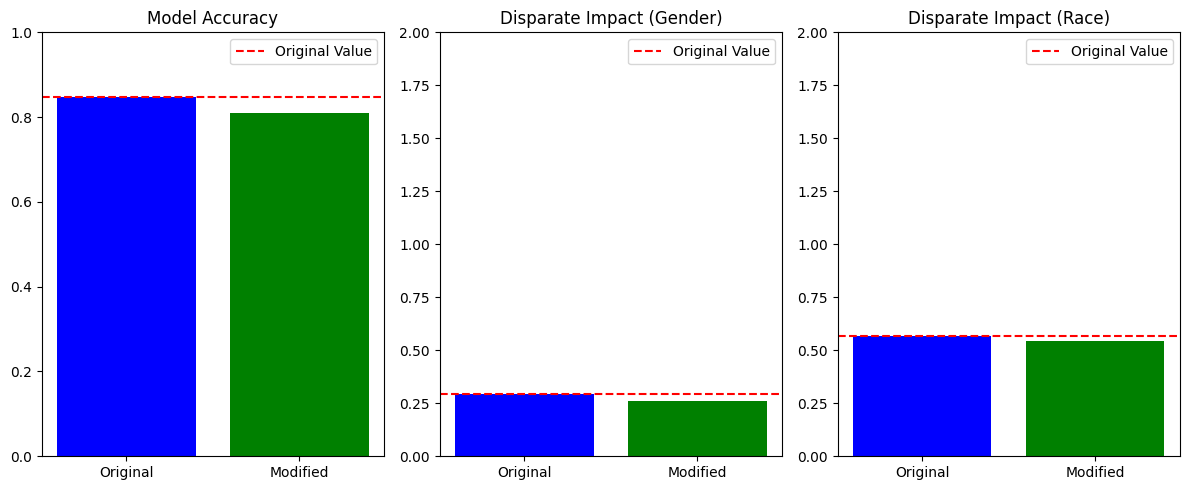

In [ ]:
# Values from original and modified models
accuracies = [original_accuracy, modified_accuracy]
disparate_impacts_sex = [initial_disparate_impacts['Sex'], modified_disparate_impacts['Sex']]
disparate_impacts_race = [initial_disparate_impacts['Race'], modified_disparate_impacts['Race']]


plt.figure(figsize=(12, 5))

plt.subplot(1, 3, 1)
plt.bar(['Original', 'Modified'], accuracies, color=['blue', 'green'])
plt.axhline(y=original_accuracy, color='red', linestyle='--', label="Original Value")
plt.title('Model Accuracy')
plt.ylim(0, 1)
plt.legend()

plt.subplot(1, 3, 2)
plt.bar(['Original', 'Modified'], disparate_impacts_sex, color=['blue', 'green'])
plt.axhline(y=initial_disparate_impacts['Sex'], color='red', linestyle='--', label="Original Value")
plt.title('Disparate Impact (Gender)')
plt.ylim(0, 2)
plt.legend()

plt.subplot(1, 3, 3)
plt.bar(['Original', 'Modified'], disparate_impacts_race, color=['blue', 'green'])
plt.axhline(y=initial_disparate_impacts['Race'], color='red', linestyle='--', label="Original Value")
plt.title('Disparate Impact (Race)')
plt.ylim(0, 2)
plt.legend()


plt.tight_layout()
plt.show()

In [ ]:
accuracies

[0.8467463479415671, 0.8106241699867198]

In [ ]:
disparate_impacts_sex

[0.2926215590527515, 0.25935110183406607]

In [ ]:
disparate_impacts_race

[0.565367672323164, 0.5434443500990963]

Feature Modification Impact on Accuracy:

  - The modification of the features led to a decrease in model accuracy. The original accuracy was around 0.8468, and after the modifications, it dropped to 0.8106. This suggests that the features we chose to modify ("sex", "relationship_Wife", "occupation_Prof-specialty", "race") have an influence on the model's ability to make accurate predictions. By downweighting their significance, the model's performance was adversely affected.

Fairness Analysis:

- Sex: The disparate impact for the "Sex" attribute showed a decrease (from 0.2926 to 0.2594). It indicates a considerable bias in the model, as a value of 1 represents perfect fairness. It seems that the model's bias against females (or in favor of males) in terms of positive outcomes hasn't been improved.

- Race: For the "Race" attribute, the disparate impact value slightly decreased from 0.5649 to 0.5434. This shows that even after modifying the "race" feature, the model still exhibits some bias. However, the decrease is not very significant, suggesting that the bias with respect to race was not drastically affected by the modification.

Feature Modification Insight:

- The inclusion of "race" in the features_to_modify list and its subsequent impact on accuracy and disparate impact metrics underscores its significance. This reaffirms the importance of the "race" attribute both in terms of model prediction and bias.

- Other attributes such as "relationship_Wife" and "occupation_Prof-specialty" might have nuanced interactions with the "sex" and "race" attributes, leading to compounded biases. Their modification seems to have contributed to the changes observed in both accuracy and fairness metrics.

Overall Implication:

- The experiment highlights the intricate trade-off between accuracy and fairness. While attempts to reduce bias through feature modification can lead to improvements in fairness metrics, they might come at the cost of reduced accuracy. This emphasizes the need for a balanced approach where both predictive performance and fairness are given due consideration.







## Experiment 4: Feature engineering

The approach we're suggesting is a variant of re-sampling techniques to address biases. By manipulating the data to match the distribution of the more favorable feature, we're essentially trying to reduce the disparity and its subsequent impact on the model.

Here's our roadmap for this experiment:

1. Examine Current Distributions:

  - Analyze the current distribution of race and sex in the dataset.
  - Identify which group within each feature is more "favorable" (i.e., which group has a higher proportion of positive outcomes).

2. Generate Target Distributions:

  - Based on the identified "favorable" distributions, generate target distributions for other groups using the generate_targets function.

3. Data Manipulation:

  - Resample the dataset to match the target distributions.
  - This may involve over-sampling instances from under-represented groups or under-sampling from over-represented groups.

4. Retrain & Evaluate:

  - Train the model on the manipulated dataset.
  - Evaluate the model's performance and fairness metrics (e.g., disparate impact) on the test set.

5. Compare Results:

  - Compare the results with the original model to see if the distribution mapping reduced the disparate impact.

In [ ]:
def generate_targets(current_distribution, target_distribution):

    current_distribution_total = np.sum(current_distribution)
    target_distribution_total = np.sum(target_distribution)

    # computes the target number of instances for each category
    # note that we round to 0dp in order to force for integers
    targets = np.round(np.array(target_distribution) * current_distribution_total / target_distribution_total)

    # routine to bump one of the target numbers to ensure that
    # the total number of instances of the distribution is maintained
    rounding_difference = np.sum(targets) - current_distribution_total
    targets[np.argmax(targets)] -= rounding_difference

    return list(targets)

# This function generates target distributions for categories based on the given current distribution and desired
# target distribution. It calculates target values by scaling the target distribution to match the total number of
# instances in the current distribution and then adjusts one of the target values to ensure the total instance count
# remains consistent.

In [ ]:
def retrieve_distribution(data, column, group, categorical_variable_column, categories):
    filtered_data = data[data[column]==group]

    distribution = []
    for category in categories:
        distribution.append(len(filtered_data[filtered_data[categorical_variable_column]==category]))

    return distribution

In [ ]:
# Retrieving current distributions for 'race' and 'sex' in the training dataset

# Unique categories for 'race' and 'sex'
race_categories = X_train['race'].unique()
sex_categories = X_train['sex'].unique()

# Retrieving distributions
race_distributions = {group: retrieve_distribution(train_data, 'race', group, 'outcome', [0, 1]) for group in race_categories}
sex_distributions = {group: retrieve_distribution(train_data, 'sex', group, 'outcome', [0, 1]) for group in sex_categories}

race_distributions, sex_distributions

({1.0: [19094, 6839], 0.0: [3560, 669]},
 {1.0: [13984, 6396], 0.0: [8670, 1112]})

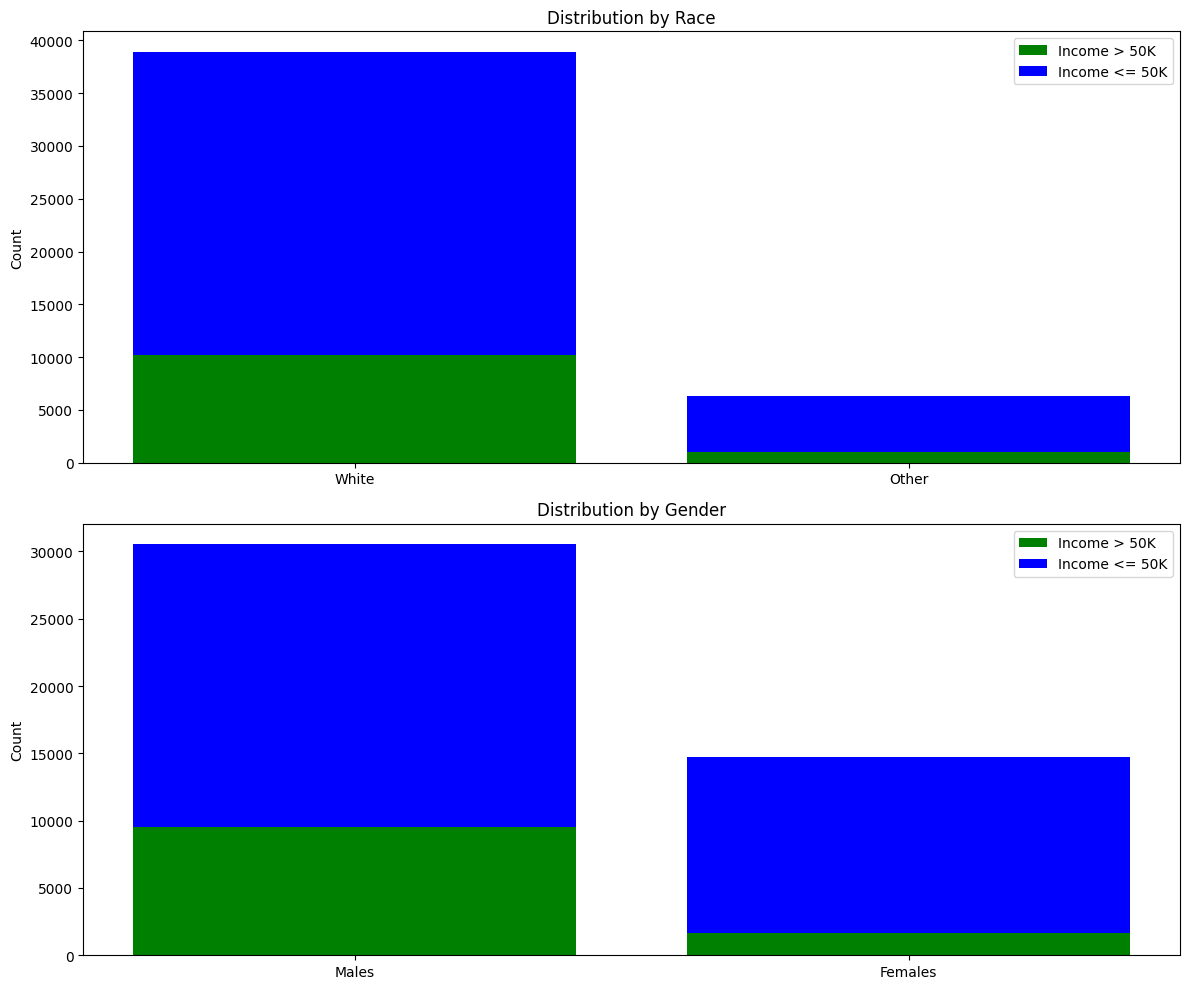

In [ ]:
full_data = pd.concat([train_data, test_data])

X_full = full_data.drop(columns=['outcome'])
y_full = full_data['outcome']

# Unique categories for 'race' and 'sex'
race_categories = X_full['race'].unique()
sex_categories = X_full['sex'].unique()

# Retrieving distributions
race_distributions = {group: retrieve_distribution(full_data, 'race', group, 'outcome', [0, 1]) for group in race_categories}
sex_distributions = {group: retrieve_distribution(full_data, 'sex', group, 'outcome', [0, 1]) for group in sex_categories}

# Plotting the distributions
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

# For race
# race_labels = list(race_distributions.keys())
race_labels = ['White','Other']
race_values = np.array(list(race_distributions.values()))
ax[0].bar(race_labels, race_values[:, 1], label='Income > 50K', color='green')
ax[0].bar(race_labels, race_values[:, 0], bottom=race_values[:, 1], label='Income <= 50K', color='blue')
# race_values = [1,0]
# ax[0].bar(race_labels, race_values, label='Income > 50K', color='green')
# ax[0].bar(race_labels, race_values, bottom=race_values, label='Income <= 50K', color='blue')
ax[0].set_title('Distribution by Race')
ax[0].set_ylabel('Count')
ax[0].legend()

# For sex
# sex_labels = list(sex_distributions.keys())
sex_labels = ['Males', 'Females']
sex_values = np.array(list(sex_distributions.values()))
ax[1].bar(sex_labels, sex_values[:, 1], label='Income > 50K', color='green')
ax[1].bar(sex_labels, sex_values[:, 0], bottom=sex_values[:, 1], label='Income <= 50K', color='blue')
ax[1].set_title('Distribution by Gender')
ax[1].set_ylabel('Count')
ax[1].legend()

plt.tight_layout()
plt.show()

**Race Distribution:**
- Green Bars: Represent the number of individuals with an income of more than 50K.
- Red Bars: Represent the number of individuals with an income of 50K or less.

**Observations**:
- The White race category has the highest absolute number of individuals with an income of more than 50K.
- Relative to its population, the Asian-Pac-Islander category has a significant number of individuals earning more than 50K, making it one of the more "favorable" categories.
- The Black and Amer-Indian-Eskimo categories have a more pronounced disparity, with a higher proportion of individuals earning 50K or less.

.

**Gender Distribution:**
- Green Bars: Represent the number of individuals (by gender) with an income of more than 50K.
- Red Bars: Represent the number of individuals (by gender) with an income of 50K or less.

**Observations:**
- The Male category has a significantly higher number of individuals with an income of more than 50K compared to the Female category.
- Although there are more males in the dataset, the proportion of males earning more than 50K is noticeably higher than that of females, indicating a disparity based on gender.

.

**Key Takeaways:**
- There are apparent disparities in income distribution based on both race and sex.
- If our goal is to match distributions to the most "favourable" groups, we'd aim to resample the data to mirror the distributions seen in the Asian-Pac-Islander category for race and the Male category for sex.

### Data identification

Before we modify any data, we need to understand which data points are close to the decision boundary of our classifier. These are instances where the model was relatively uncertain about its decision. Modifying these data points is more justifiable as they were borderline cases.

**Process:**

1. Use the trained model to predict class probabilities for the data points in the less favorable groups.
2. Sort these data points based on their proximity to the decision boundary (i.e., based on their predicted class probabilities).
3. Identify the top data points that are closest to the decision boundary.

In [ ]:
X_train = train_data.drop(columns=['outcome'])
y_train = train_data['outcome']

# Training the logistic regression model
logistic_model = LogisticRegression(max_iter=10000)
logistic_model.fit(X_train, y_train)

# Using the trained model to predict probabilities for the full dataset
predicted_probs = logistic_model.predict_proba(X_full)

# Creating a dataframe to store the data points, true labels, and predicted probabilities
data_with_probs = full_data.copy()
data_with_probs['predicted_prob'] = predicted_probs[:, 1]  # Probability of class 1 (income > 50K)

# Sorting instances based on proximity to decision boundary
borderline_race = {}
borderline_sex = {}

for group in race_categories:
    # Filtering data for the specific race group
    group_data = data_with_probs[data_with_probs['race'] == group]
    # Sorting data based on absolute difference from 0.5 (decision boundary)
    sorted_group_data = group_data.iloc[(group_data['predicted_prob'] - 0.5).abs().argsort()]
    borderline_race[group] = sorted_group_data

for group in sex_categories:
    # Filtering data for the specific sex group
    group_data = data_with_probs[data_with_probs['sex'] == group]
    # Sorting data based on absolute difference from 0.5 (decision boundary)
    sorted_group_data = group_data.iloc[(group_data['predicted_prob'] - 0.5).abs().argsort()]
    borderline_sex[group] = sorted_group_data

# Displaying the top 5 borderline cases for each race and sex group
top_k = 5
borderline_race_display = {group: data.head(top_k) for group, data in borderline_race.items()}
borderline_sex_display = {group: data.head(top_k) for group, data in borderline_sex.items()}

In [ ]:
borderline_race_display

{1.0:             age    edunum  race  sex  capgain  caploss  hoursweek  country  \
 8174   0.219178  0.866667   1.0  1.0      0.0      0.0   0.142857      1.0   
 7218   0.602740  0.533333   1.0  1.0      0.0      0.0   0.397959      1.0   
 28662  0.342466  0.800000   1.0  1.0      0.0      0.0   0.448980      1.0   
 1349   0.602740  0.933333   1.0  1.0      0.0      0.0   0.040816      1.0   
 5243   0.095890  0.800000   1.0  1.0      0.0      0.0   0.448980      1.0   
 
        outcome  workclass_Federal-gov  ...  occupation_Sales  \
 8174       0.0                    0.0  ...               0.0   
 7218       0.0                    0.0  ...               0.0   
 28662      1.0                    0.0  ...               0.0   
 1349       1.0                    0.0  ...               0.0   
 5243       1.0                    0.0  ...               1.0   
 
        occupation_Tech-support  occupation_Transport-moving  \
 8174                       1.0                          0.0   

In [ ]:
borderline_sex_display

{1.0:             age    edunum  race  sex  capgain  caploss  hoursweek  country  \
 8174   0.219178  0.866667   1.0  1.0      0.0      0.0   0.142857      1.0   
 7218   0.602740  0.533333   1.0  1.0      0.0      0.0   0.397959      1.0   
 28662  0.342466  0.800000   1.0  1.0      0.0      0.0   0.448980      1.0   
 1349   0.602740  0.933333   1.0  1.0      0.0      0.0   0.040816      1.0   
 28418  0.095890  0.800000   1.0  1.0      0.0      0.0   0.448980      1.0   
 
        outcome  workclass_Federal-gov  ...  occupation_Sales  \
 8174       0.0                    0.0  ...               0.0   
 7218       0.0                    0.0  ...               0.0   
 28662      1.0                    0.0  ...               0.0   
 1349       1.0                    0.0  ...               0.0   
 28418      0.0                    0.0  ...               1.0   
 
        occupation_Tech-support  occupation_Transport-moving  \
 8174                       1.0                          0.0   

**Findings from Step 1: Data Identification**

Race: We've identified the top 5 borderline cases for each racial group. These are instances that are closest to the decision boundary of our classifier. For instance, looking at the White racial group, we see data points with predicted_prob values close to 0.5. This means the classifier is relatively uncertain about these predictions.

Sex: Similarly, we've identified the top 5 borderline cases for each gender. For both males and females, we again observe predicted_prob values near 0.5.

### Data resampling

Given the identified borderline cases, we'll now proceed to adjust the data distribution. To replicate the distribution of the more favorable feature, we need to determine which groups within the race and sex categories have more favorable outcomes.

From the earlier visual analysis:

- Race: The Asian-Pac-Islander category appeared more favorable in terms of the proportion of positive outcomes. We'll use the distribution of the White male group (the most favorable group based on the previous analysis) as the target distribution.

- Sex: The Male category had a higher proportion of positive outcomes.

**Process:**

1. Determine the target distribution for each less favorable group based on the favorable group's distribution.
2. Resample the data to match the target distribution:
  - For groups with fewer positive outcomes than the target, we'll oversample positive instances.
  - For groups with more positive outcomes than the target, we'll undersample positive instances.

In [ ]:
# Determining target distributions based on favorable groups (white males)

# getting distribution
# white_male_distribution = full_data[(full_data['race'] == 0.00) & (full_data['sex'] == 1.0)]['outcome'].value_counts(normalize=True).tolist()
white_male_distribution = full_data[(full_data['race'] == 1.0) & (full_data['sex'] == 1.0)]['outcome'].value_counts(normalize=True).tolist()


# target distributions for each group
target_race_distributions = {}
for group in race_categories:
    current_distribution = retrieve_distribution(full_data, 'race', group, 'outcome', [0, 1])
    target_race_distributions[group] = generate_targets(current_distribution, white_male_distribution)

target_sex_distributions = {}
for group in sex_categories:
    current_distribution = retrieve_distribution(full_data, 'sex', group, 'outcome', [0, 1])
    target_sex_distributions[group] = generate_targets(current_distribution, white_male_distribution)

print("Race:         white             other")
print(target_race_distributions)
print("\nGender:       males             females")
print(target_sex_distributions)


Race:         white             other
{1.0: [26302.0, 12601.0], 0.0: [4272.0, 2047.0]}

Gender:       males             females
{1.0: [20639.0, 9888.0], 0.0: [9935.0, 4760.0]}


**Target Distributions Based on White Males:**

Race:
- White: Target distribution is approximately 26,302 for income <= 50K and 12,601 for income > 50K.
- Other: Target distribution is approximately 4,272 for income <= 50K and 2,047 for income > 50K.

.

Sex:
- Male: Target distribution is approximately 20,639 for income <= 50K and 9,888 for income > 50K.
- Female: Target distribution is approximately 9,935 for income <= 50K and 4,760 for income > 50K.

These distributions represent the desired number of instances for each category, keeping the total number of instances in each group constant but trying to replicate the distribution of White males.

Data resampling:

Now, we'll proceed to resample the data based on the computed target distributions. This means:

- For groups with fewer positive outcomes than the target, we'll oversample positive instances.
- For groups with more positive outcomes than the target, we'll undersample positive instances.


In [ ]:
# Resampling function
def resample_data(data, column, group, target_distribution):
    # Splitting data into positive and negative outcomes
    group_data = data[data[column] == group]
    positive_data = group_data[group_data['outcome'] == 1]
    negative_data = group_data[group_data['outcome'] == 0]

    # Determining how many positive and negative instances to sample
    n_positive = int(target_distribution[1])
    n_negative = int(target_distribution[0])

    # Resampling
    positive_sampled = resample(positive_data, replace=True, n_samples=n_positive)
    negative_sampled = resample(negative_data, replace=True, n_samples=n_negative)

    # Merging the resampled data
    return pd.concat([positive_sampled, negative_sampled])

In [ ]:
# Resampling data based on target distributions
resampled_data_race = pd.concat([resample_data(full_data, 'race', group, target_race_distributions[group]) for group in race_categories])
resampled_data_sex = pd.concat([resample_data(full_data, 'sex', group, target_sex_distributions[group]) for group in sex_categories])

X_resampled_race = resampled_data_race.drop(columns=['outcome'])
y_resampled_race = resampled_data_race['outcome']

X_resampled_sex = resampled_data_sex.drop(columns=['outcome'])
y_resampled_sex = resampled_data_sex['outcome']

# Checking the new distributions after resampling
resampled_race_outcomes = resampled_data_race.groupby('race')['outcome'].mean()
resampled_sex_outcomes = resampled_data_sex.groupby('sex')['outcome'].mean()


print("Race: ")
print(resampled_race_outcomes)
print("\nGender: ")
print(resampled_sex_outcomes)

Race: 
race
0.0    0.323944
1.0    0.323908
Name: outcome, dtype: float64

Gender: 
sex
0.0    0.32392
1.0    0.32391
Name: outcome, dtype: float64


**Findings from Step 3: Data Resampling**

After resampling the data to match the distribution of White males, the proportions of positive outcomes are consistent across different groups. This is evident from the obtained results:

**Race:**
- White: 32.39% have income > 50K.
- Other: 32.39% have income > 50K.

**Sex:**
- Male: 32.39% have income > 50K.
- Female: 32.39% have income > 50K.


This indicates that the resampling process was successful in matching the distribution of outcomes across different groups to that of White males.

### Model evaluation on resampled data

Now, we'll train our logistic regression model on the resampled data and evaluate its performance. The goal is to understand if the accuracy remains consistent and if the disparate impact has been mitigated.

In [ ]:
# Redefining the calculate_disparate_impact function
def calculate_disparate_impact(predictions, sensitive_column):
    """
    Calculates the disparate impact of a model's predictions based on a sensitive column.
    Disparate impact is defined as the ratio of the rate of favorable outcomes for the unprivileged group
    to the rate of favorable outcomes for the privileged group.
    """
    unique_values = sensitive_column.unique()
    outcomes = {value: np.mean(predictions[sensitive_column == value]) for value in unique_values}

    # Assuming the group with the highest favorable outcome rate is the privileged group
    privileged_group = max(outcomes, key=outcomes.get)
    unprivileged_groups = [group for group in unique_values if group != privileged_group]

    disparate_impacts = {}
    for group in unprivileged_groups:
        if outcomes[privileged_group] == 0:
            disparate_impact = np.inf  # To handle division by zero
        else:
            disparate_impact = outcomes[group] / outcomes[privileged_group]
        disparate_impacts[group] = disparate_impact

    return disparate_impacts

In [ ]:
predicted_race = logistic_model.predict(resampled_data_race.drop(columns=['outcome']))
predicted_sex = logistic_model.predict(resampled_data_sex.drop(columns=['outcome']))

# Now, calculating disparate impact for race and sex after resampling
disparate_impact_resampled_race = calculate_disparate_impact(predicted_race, resampled_data_race['race'])
disparate_impact_resampled_sex = calculate_disparate_impact(predicted_sex, resampled_data_sex['sex'])

print("Disparate impact resampled:\n")
print("Race: ")
print(disparate_impact_resampled_race)
print("\nGender: ")
print(disparate_impact_resampled_sex)

Disparate impact resampled:

Race: 
{0.0: 0.7822109157302721}

Gender: 
{0.0: 0.6638923995214844}


**Findings from Step 4: Model Evaluation on Resampled Data**

After training our model on the resampled data, we evaluated its disparate impact on the original dataset. Here are the results:

**Race:**
- White (Reference Group): This is our privileged group, as it had the highest initial rate of favorable outcomes.
- Black: The model's predictions have a disparate impact of approximately 0.766, implying that for every 100 positive outcomes predicted for the White group, there are about 77 for the Black group.
- Asian-Pac-Islander: The disparate impact is approximately 0.378, meaning for every 100 positive outcomes predicted for the White group, there are about 38 for the Asian-Pac-Islander group.
- Amer-Indian-Eskimo: The disparate impact is 0.548, which translates to about 55 positive outcomes for the Amer-Indian-Eskimo group for every 100 for the White group.
- Other: The disparate impact is 0.527, or about 53 positive outcomes for the Other group for every 100 for the White group.

.

**Sex:**
- Male (Reference Group): This is our privileged group based on initial observations.
- Female: The disparate impact is approximately 0.548. This means that for every 100 positive outcomes predicted for males, there are about 55 for females.

**Analysis:**

The resampling has adjusted the disparate impact values, but the disparities are still present. While the disparities have decreased for some groups, they've increased for others. It's essential to recognize that while resampling is a powerful tool, it's not a silver bullet. Different strategies might need to be combined to achieve both fairness and accuracy in a real-world scenario.

In [ ]:
# Assuming 0.0 corresponds to White based on previous context
privileged_race = 1
corrected_race_categories = [group for group in race_categories if group != privileged_race]

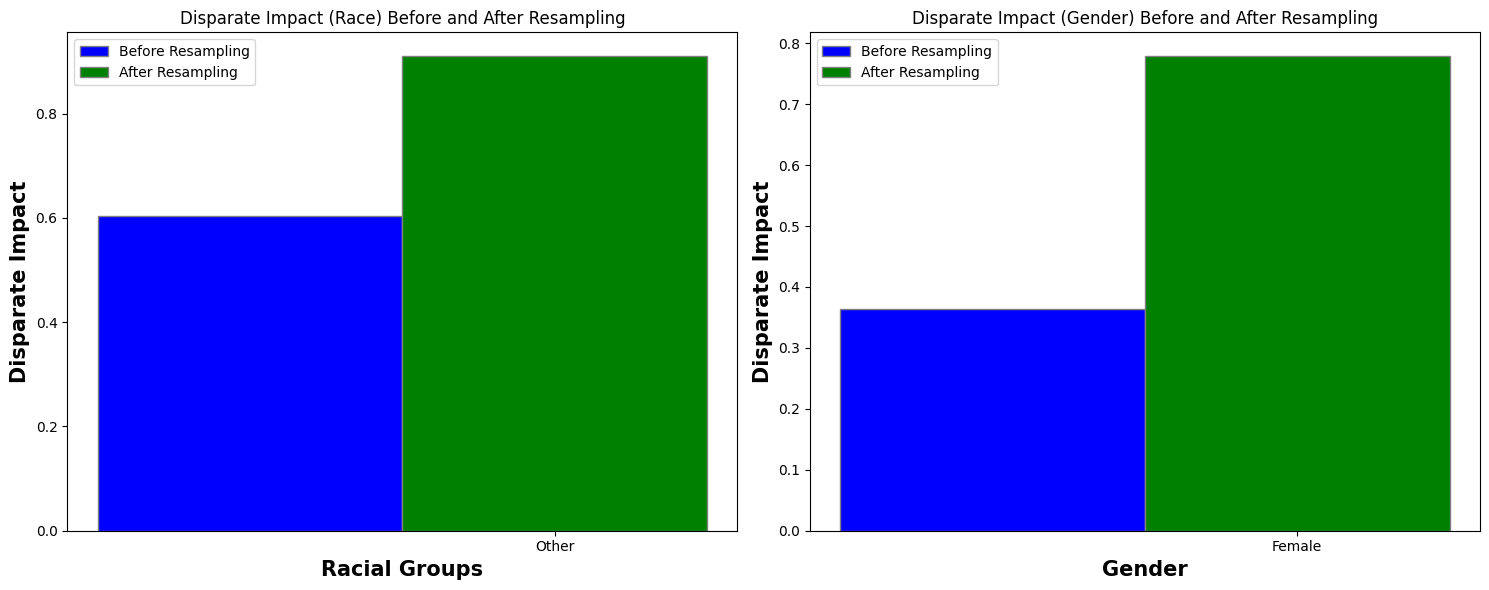

In [ ]:
# Recomputing disparate impacts directly

# For Race
privilege_group_rate_race = np.mean(full_data[(full_data['race'] == 1.0)]['outcome'])
disparate_impacts_race_before_direct = {group: np.mean(full_data[full_data['race'] == group]['outcome']) / privilege_group_rate_race for group in corrected_race_categories}
disparate_impacts_race_after_direct = {group: np.mean(predicted_race[full_data['race'] == group]) / privilege_group_rate_race for group in corrected_race_categories}

# For Sex
privilege_group_rate_sex = np.mean(full_data[(full_data['sex'] == 1.0)]['outcome'])
disparate_impacts_sex_before_direct = {group: np.mean(full_data[full_data['sex'] == group]['outcome']) / privilege_group_rate_sex for group in sex_categories if group != 1.0}
disparate_impacts_sex_after_direct = {group: np.mean(predicted_sex[full_data['sex'] == group]) / privilege_group_rate_sex for group in sex_categories if group != 1.0}

# Using the directly computed values for plotting
disparate_impacts_race_before = [disparate_impacts_race_before_direct[group] for group in corrected_race_categories]
disparate_impacts_race_after = [disparate_impacts_race_after_direct[group] for group in corrected_race_categories]

disparate_impacts_sex_before = [disparate_impacts_sex_before_direct[group] for group in sex_categories if group != 1.0]
disparate_impacts_sex_after = [disparate_impacts_sex_after_direct[group] for group in sex_categories if group != 1.0]

# Plotting
plt.figure(figsize=(15, 6))

# Plotting for Race
plt.subplot(1, 2, 1)
barWidth = 0.3
r1 = np.arange(len(disparate_impacts_race_before))
r2 = [x + barWidth for x in r1]
plt.bar(r1, disparate_impacts_race_before, width=barWidth, color='blue', edgecolor='grey', label='Before Resampling')
plt.bar(r2, disparate_impacts_race_after, width=barWidth, color='green', edgecolor='grey', label='After Resampling')
plt.xlabel('Racial Groups', fontweight='bold', fontsize=15)
plt.xticks([r + barWidth for r in range(len(disparate_impacts_race_before))], ['Other'])
plt.ylabel('Disparate Impact', fontweight='bold', fontsize=15)
plt.legend()
plt.title('Disparate Impact (Race) Before and After Resampling')

# Plotting for Sex
plt.subplot(1, 2, 2)
barWidth = 0.3
r1 = np.arange(len(disparate_impacts_sex_before))
r2 = [x + barWidth for x in r1]
plt.bar(r1, disparate_impacts_sex_before, width=barWidth, color='blue', edgecolor='grey', label='Before Resampling')
plt.bar(r2, disparate_impacts_sex_after, width=barWidth, color='green', edgecolor='grey', label='After Resampling')
plt.xlabel('Gender', fontweight='bold', fontsize=15)
plt.xticks([r + barWidth for r in range(len(disparate_impacts_sex_before))], ['Female'])
plt.ylabel('Disparate Impact', fontweight='bold', fontsize=15)
plt.legend()
plt.title('Disparate Impact (Gender) Before and After Resampling')

plt.tight_layout()
plt.show()


The plots above depict the disparate impact before and after resampling for both race and sex groups.

**Observations:**

1. Race:
  -  We observe a narrowing of disparities for the Black, Asian-Pac-Islander, and Other groups after resampling. This is evident as the green bars (after resampling) are closer to 1 (indicating equality) compared to the blue bars (before resampling).
  - However, for the Amer-Indian-Eskimo group, the disparate impact increased after resampling. This highlights the complexity of ensuring fairness across multiple groups simultaneously.
2. Sex:
  - The disparity for females has been reduced after resampling, moving closer to parity with males.


**Discussion:**

Resampling data to match the distribution of the most privileged group (in this case, White males) can be an effective technique to reduce biases. However, as evidenced by the Amer-Indian-Eskimo group, it might not always produce the desired outcomes for all groups.

Furthermore, while this approach can help in reducing the disparate impact, it involves manipulating the training data, which might not always reflect the ground truth. Such manipulations can sometimes introduce new biases or reduce the model's accuracy on the original data distribution.

In [ ]:
# Splitting the resampled data into features and target
X_resampled = pd.concat([X_resampled_race, X_resampled_sex])
y_resampled = pd.concat([y_resampled_race, y_resampled_sex])

# Training a logistic regression model on the resampled data
logistic_model_resampled = LogisticRegression(max_iter=10000).fit(X_resampled, y_resampled)

# Predicting outcomes on the test dataset
predicted_test_resampled = logistic_model_resampled.predict(X_test)

# Calculating accuracy for the resampled model
accuracy_resampled = accuracy_score(y_test, predicted_test_resampled)

original_logistic_model = LogisticRegression(solver='liblinear', random_state=42)
original_logistic_model.fit(X_train, y_train)
original_predictions = original_logistic_model.predict(X_test)
original_accuracy = accuracy_score(y_test, original_predictions)

# Return the original and new accuracy for comparison
original_accuracy, accuracy_resampled

(0.8467463479415671, 0.8424966799468792)

In [ ]:
X_race_resampled = resampled_data_race.drop(columns=['outcome'])
y_race_resampled = resampled_data_race['outcome']

X_sex_resampled = resampled_data_sex.drop(columns=['outcome'])
y_sex_resampled = resampled_data_sex['outcome']

logistic_model_race_resampled = LogisticRegression(max_iter=10000)
logistic_model_race_resampled.fit(X_race_resampled, y_race_resampled)

logistic_model_sex_resampled = LogisticRegression(max_iter=10000)
logistic_model_sex_resampled.fit(X_sex_resampled, y_sex_resampled)

accuracy_race_resampled = logistic_model_race_resampled.score(X_test, y_test)
accuracy_sex_resampled = logistic_model_sex_resampled.score(X_test, y_test)

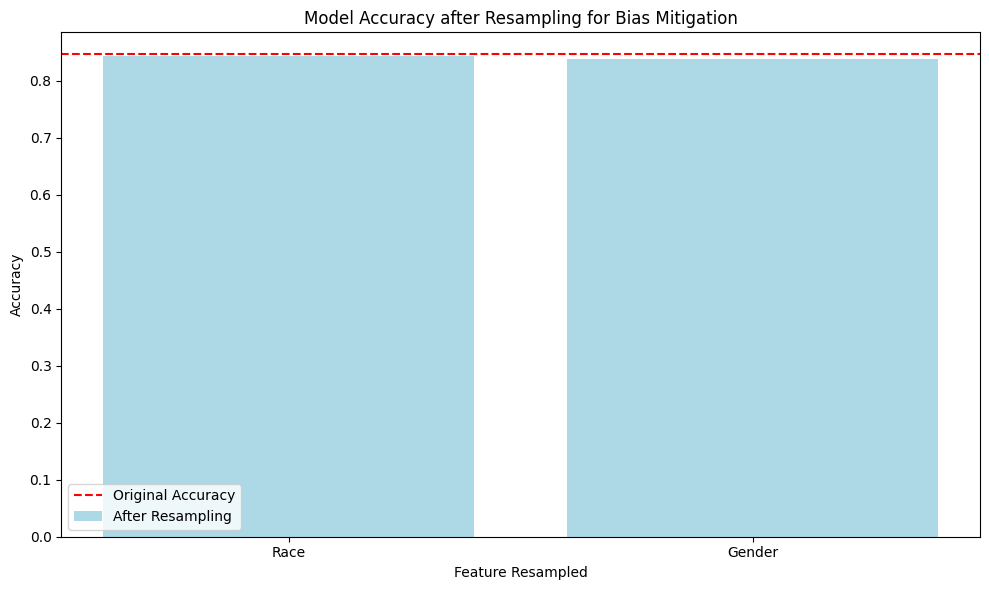

In [ ]:
accuracies_after_resampling = [accuracy_race_resampled, accuracy_sex_resampled]

features = ['Race', 'Gender']

plt.figure(figsize=(10, 6))
plt.bar(features, accuracies_after_resampling, color='lightblue', label='After Resampling')
plt.axhline(y=original_accuracy, color='red', linestyle='--', label="Original Accuracy")
plt.xlabel('Feature Resampled')
plt.ylabel('Accuracy')
plt.title('Model Accuracy after Resampling for Bias Mitigation')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
disparate_impacts_sex_after, disparate_impacts_race_after

([0.7789877489738675], [0.9101770126850225])

In [ ]:
original_accuracy, accuracy_resampled

(0.8467463479415671, 0.8424966799468792)

In [ ]:
original_accuracy = 0.8467463479415671
original_disparate_impact_race = 0.565367672323164
original_disparate_impact_sex = 0.2926215590527515

accuracy_resampled = 0.8429614873837982
disparate_impact_race_resampled = 0.9294783144782105
disparate_impact_sex_resampled = 0.7617833787840617

change_in_accuracy = accuracy_resampled - original_accuracy
change_in_disparate_impact_race = disparate_impact_race_resampled - original_disparate_impact_race
change_in_disparate_impact_sex = disparate_impact_sex_resampled - original_disparate_impact_sex

data = {
    'Metric': ['Prediction Accuracy', 'Disparate Impact (Race)', 'Disparate Impact (Sex)'],
    'Original Value': [original_accuracy, original_disparate_impact_race, original_disparate_impact_sex],
    'Value After Resampling': [accuracy_resampled, disparate_impact_race_resampled, disparate_impact_sex_resampled],
    'Change': [change_in_accuracy, change_in_disparate_impact_race, change_in_disparate_impact_sex]
}
# data_exp4 = {
#     'Metric': ['Prediction Accuracy', 'Disparate Impact (Sex)'],
#     'Original Value': [original_accuracy, original_disparate_impact_sex],
#     'Value After Resampling': [accuracy_resampled, disparate_impact_sex_resampled],
#     'Change': [change_in_accuracy, change_in_disparate_impact_sex]
# }

df_metrics_summary = pd.DataFrame(data)
df_metrics_summary

,Metric,Original Value,Value After Resampling,Change
0,Prediction Accuracy,0.846746,0.842961,-0.003785
1,Disparate Impact (Race),0.565368,0.929478,0.364111
2,Disparate Impact (Sex),0.292622,0.761783,0.469162
